## Board Games - Recommender System

**The goal here is to make a supervised personalized recommendation system using collaborative filtering**

- **Recommendation Systems** (also known as recommendation engines) are a relatively new prediction method that uses algorithms such as **Collaborative filtering** (CF) and Clustering that try to provide an insight not seen before by the user. In our case we initially try to implement a CF using a dataset with over 15 million rows. These reviews were scraped from https://boardgamegeek.com/.

- **Offering some context to board games**, the definition is pretty open, but you basically need a mechanic to use during the game and some sort of definition of who and how someone can win in that game. We can find games that uses pieces, boards, cards, dice, coins, resources and nowadays we even have eletronics involved in board games.

> **Our data counts with 3 different datasets:**
>- **bgg_reviews**: Board Game Geek reviews with over 15 million reviews
>- **games**: Information for the board game, with some other information like number of players and designer
>- **reviews_summary**: A summary of the boardgame, how it is ranked on the website, and its average rating and how many users voted

In [6]:
import random
import pickle
import pandas as pd
import seaborn as sns
from surprise import accuracy
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise import Reader, Dataset, SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.similarities import cosine, msd, pearson
import warnings; warnings.simplefilter('ignore')

In [7]:
bgg_reviews = pd.read_csv('../../../bgg-15m-reviews.csv')
games = pd.read_csv('../../../games_detailed_info.csv')
reviews_summary = pd.read_csv('../../../2020-08-19.csv')

### Bring useful functions to the data exploration

In [13]:
def basic_info(data):
    """
    Gets basic information to understand more of the data, also useful to delete columns that we know are categorical
    """
    print("Dataset shape is: ", data.shape)
    print("Dataset size is: ", data.size)
    print(data.duplicated().sum())
    print("Dataset columns are: ", data.columns)
    print("Dataset info is: ", data.info())
    categorical = []
    numerical = []
    for i in data.columns:
        if data[i].dtype == object:
            categorical.append(i)
        else:
            numerical.append(i)
    print("Categorical variables are:\n ", categorical)
    print("Numerical variables are:\n ", numerical)
    return categorical, numerical

In [14]:
def columns_w_nan(data, y=0.4):
    """
    Returns the columns that have NaN values and it's percentage related to the total number;
    Also returns a list with the name(s) of the columns that have y% made out of missing value.
    """
    
    temp = []
    temp_perce = []
    for x in data.columns:
        if data[x].isna().sum() > 0:
            percentage_of_data = data[x].isna().sum()/(list(data.shape)[0])
            print("Row: {} : is made {}% of NaN Values.".format(x, percentage_of_data.round(3)))
            if percentage_of_data > y:
                temp.append(x)
                temp_perce.append(percentage_of_data)
    if len(temp) > 0:
        print('')            
        print(temp)
        
    else:
        print('No NaN Values found')

### First analysis of "bgg_reviews" dataset

In [15]:
basic_info(bgg_reviews)

Dataset shape is:  (15823269, 6)
Dataset size is:  94939614
0
Dataset columns are:  Index(['Unnamed: 0', 'user', 'rating', 'comment', 'ID', 'name'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15823269 entries, 0 to 15823268
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 724.3+ MB
Dataset info is:  None
Categorical variables are:
  ['user', 'comment', 'name']
Numerical variables are:
  ['Unnamed: 0', 'rating', 'ID']


(['user', 'comment', 'name'], ['Unnamed: 0', 'rating', 'ID'])

In [16]:
columns_w_nan(bgg_reviews, 0.3)

Row: user : is made 0.0% of NaN Values.
Row: comment : is made 0.811% of NaN Values.

['comment']


In [17]:
# We drop comment since it has so many NaN values and Unnamed that we now is a duplicate of the index
bgg_reviews.drop(columns=['comment', 'Unnamed: 0'], inplace=True)

In [18]:
# We drop the remaining NaN values on the "user" column
bgg_reviews.dropna(inplace=True)

### First analysis of "games" dataset

In [10]:
basic_info(games)

Dataset shape is:  (19230, 56)
Dataset size is:  1076880
0
Dataset columns are:  Index(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage',
       'suggested_language_dependence', 'playingtime', 'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic',
       'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher',
       'usersrated', 'average', 'bayesaverage', 'Board Game Rank',
       'Strategy Game Rank', 'Family Game Rank', 'stddev', 'median', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments', 'numweights',
       'averageweight', 'boardgameintegration', 'boardgamecompilation',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank',
       '

(['type',
  'thumbnail',
  'image',
  'primary',
  'alternate',
  'description',
  'suggested_num_players',
  'suggested_playerage',
  'suggested_language_dependence',
  'boardgamecategory',
  'boardgamemechanic',
  'boardgamefamily',
  'boardgameexpansion',
  'boardgameimplementation',
  'boardgamedesigner',
  'boardgameartist',
  'boardgamepublisher',
  'boardgameintegration',
  'boardgamecompilation'],
 ['Unnamed: 0',
  'id',
  'yearpublished',
  'minplayers',
  'maxplayers',
  'playingtime',
  'minplaytime',
  'maxplaytime',
  'minage',
  'usersrated',
  'average',
  'bayesaverage',
  'Board Game Rank',
  'Strategy Game Rank',
  'Family Game Rank',
  'stddev',
  'median',
  'owned',
  'trading',
  'wanting',
  'wishing',
  'numcomments',
  'numweights',
  'averageweight',
  'Party Game Rank',
  'Abstract Game Rank',
  'Thematic Rank',
  'War Game Rank',
  'Customizable Rank',
  "Children's Game Rank",
  'RPG Item Rank',
  'Accessory Rank',
  'Video Game Rank',
  'Amiga Rank',
  'Co

In [11]:
columns_w_nan(games, 0.5)

Row: thumbnail : is made 0.001% of NaN Values.
Row: image : is made 0.001% of NaN Values.
Row: alternate : is made 0.6% of NaN Values.
Row: description : is made 0.0% of NaN Values.
Row: suggested_playerage : is made 0.122% of NaN Values.
Row: suggested_language_dependence : is made 0.134% of NaN Values.
Row: boardgamecategory : is made 0.011% of NaN Values.
Row: boardgamemechanic : is made 0.081% of NaN Values.
Row: boardgamefamily : is made 0.233% of NaN Values.
Row: boardgameexpansion : is made 0.751% of NaN Values.
Row: boardgameimplementation : is made 0.787% of NaN Values.
Row: boardgamedesigner : is made 0.022% of NaN Values.
Row: boardgameartist : is made 0.281% of NaN Values.
Row: Strategy Game Rank : is made 0.892% of NaN Values.
Row: Family Game Rank : is made 0.896% of NaN Values.
Row: boardgameintegration : is made 0.926% of NaN Values.
Row: boardgamecompilation : is made 0.964% of NaN Values.
Row: Party Game Rank : is made 0.97% of NaN Values.
Row: Abstract Game Rank : is

In [19]:
# We drop the columns that we don't plan to use for now, another reason would be the high number of NaN values
games = games.drop(columns=['Unnamed: 0', 'alternate', 'boardgameexpansion', 'boardgameimplementation',
                            'Strategy Game Rank', 'Family Game Rank', 'boardgameintegration',
                            'boardgamecompilation', 'Party Game Rank', 'Abstract Game Rank',
                            'Thematic Rank', 'War Game Rank', 'Customizable Rank', "Children's Game Rank",
                            'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
                            'Commodore 64 Rank', 'Arcade Rank', 'Atari ST Rank'])
games.dropna(inplace=True)

In [13]:
# And that's how it looks like:
games.head(3)

,type,id,thumbnail,image,primary,description,yearpublished,minplayers,maxplayers,suggested_num_players,...,Board Game Rank,stddev,median,owned,trading,wanting,wishing,numcomments,numweights,averageweight
0,boardgame,30549,https://cf.geekdo-images.com/thumb/img/HEKrtpT...,https://cf.geekdo-images.com/original/img/j-pf...,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,"[OrderedDict([('@numplayers', '1'), ('result',...",...,91,1.32632,0,144727,2191,640,8571,15778,5232,2.4148
1,boardgame,822,https://cf.geekdo-images.com/thumb/img/kqE4YJS...,https://cf.geekdo-images.com/original/img/o4p6...,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,"[OrderedDict([('@numplayers', '1'), ('result',...",...,173,1.30369,0,140066,1587,539,6286,17720,7304,1.9158
2,boardgame,13,https://cf.geekdo-images.com/thumb/img/g8LvJsd...,https://cf.geekdo-images.com/original/img/A-0y...,Catan,"In Catan (formerly The Settlers of Catan), pla...",1995,3,4,"[OrderedDict([('@numplayers', '1'), ('result',...",...,381,1.47908,0,144656,1825,474,5310,17859,7187,2.3264


In [14]:
# That's our first EDA and preprocessing of the data
# We set random_state for reproducibility.
bgg_reviews.sample(3, random_state=22)

,user,rating,ID,name
13907171,DeanMary,8.0,6137,Drive
147029,DarrylFerster,10.0,10630,Memoir '44
13243091,Scubaroo,8.0,175695,Minerva


- Since we do not plan to use comments (in reality those are qualitative reviews) for now and they have a lot of missing values (around 80%), we drop them.
- We also drop 'Unnamed: 0' because we notice it is a repeat of the index.
- The other column we are going to drop in the future is the 'name', because it is represented already by ID.

We went to the website to verify if it is the same ID or it was assigned on the making of the dataset:

![title](../capimages/part_1_install.png)

King of Tokyo = 70323, we are good to go. (Great game by the way, and one of the coolest dice I have ever seen)

**How about what are the games with the biggest number of reviews in the website?**

Text(0.5, 0, 'totalCount')

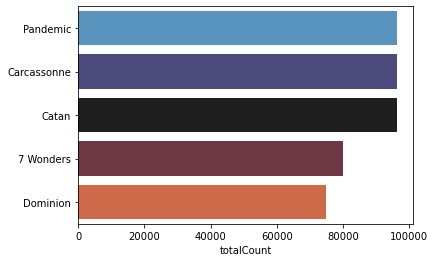

In [15]:
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
ax = sns.barplot(x=list(bgg_reviews['name'].value_counts()[0:5]),
                 y=bgg_reviews['name'].value_counts()[0:5].keys(), data=bgg_reviews, palette="icefire")
ax.set_xlabel('totalCount')


- Close fight on top 3! Catan and Carcassone are classics from the 2000's while Pandemic and 7 Wonders came a little bit after that.

**How is the distribuition of number of reviews?**

Text(0.5, 1.0, 'Distribuition of reviews by game')

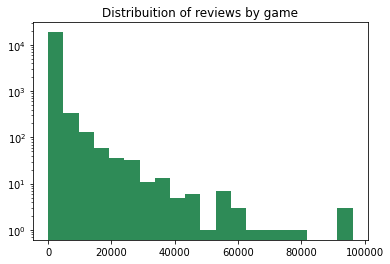

In [16]:
# Number of reviews destribuition. We can see that we have the majority of the games with "low" number of reviews
plt.hist(bgg_reviews['ID'].value_counts(), bins=20, color='seagreen', log=True)
plt.title('Distribuition of reviews by game')

- Like we would suspect: It is skewed to the right, meaning just a few had a huge amount of reviews/votes.

In [17]:
# Looking at how much "low" actually is:
bgg_reviews['ID'].value_counts().describe()
# We can see that the 75% is actually 378, but the mean is 818. Meaning we have some outliers bringing the value upwards.

count    19330.000000
mean       818.582669
std       3370.681916
min         30.000000
25%         55.000000
50%        119.000000
75%        378.000000
max      96234.000000
Name: ID, dtype: float64

**Another important feature in games is the "weight", that is how complicated a game is:**


There is a well-known bias to give higher ratings to more complex games. That could be for several reasons that we are not even going to try to guess, but we should check for that in case we want to use on a more precise recommendation.

In [18]:
# Using describe we can have a quick overview of the values, the mean and the 75% percentile are pretty close, which 
# once again points to some outliers to higher numbers
games['averageweight'].describe()

count    8819.000000
mean        2.216246
std         0.828627
min         0.000000
25%         1.564800
50%         2.142900
75%         2.771400
max         4.900000
Name: averageweight, dtype: float64

In [19]:
bgg_reviews['rating'].describe()

count    1.582320e+07
mean     7.054855e+00
std      1.599638e+00
min      1.401300e-45
25%      6.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

**Since the information we need is in 2 different tables, lets join them together so we can analyze the rating per weights**

In [20]:
# We first get the columns from "games" that we are interested - that is the ID and the Weight
games_weight = games[['id', 'averageweight', 'boardgamedesigner', 'thumbnail', 'image', 'primary']]

In [21]:
games_weight.columns = ['id', 'averageweight', 'boardgamedesigner', 'thumbnail', 'image', 'name']

In [22]:
games_weight.isna().sum()

id                   0
averageweight        0
boardgamedesigner    0
thumbnail            0
image                0
name                 0
dtype: int64

In [23]:
# We rename the "ID" to "id" on the bgg_reviews dataset:
bgg_reviews.columns = ['user', 'rating', 'id', 'name']

In [24]:
rating_weight = bgg_reviews.merge(games_weight)

In [25]:
rating_weight.isna().sum()

user                 0
rating               0
id                   0
name                 0
averageweight        0
boardgamedesigner    0
thumbnail            0
image                0
dtype: int64

In [28]:
rating_weight.averageweight.max()

9.8

In [27]:
# To both "Weight" and "Rating" be on the same scale, we multiply the weight by 2
rating_weight['averageweight'] = rating_weight['averageweight']*2

In [29]:
# For a quick analysis we drop the user column and create a new dataset because we might use the first one in the future
rating_weight_comparison = rating_weight.drop(columns=['user'])

In [30]:
rating_weight_comparison = rating_weight_comparison.groupby('name').mean()

In [31]:
rating_weight_comparison =  rating_weight_comparison.sort_values(by='averageweight', ascending=True)

In [32]:
# For some reason there are some 0's on weights - lets assume they are mistakes and remove them
rating_weight_comparison['averageweight'] = rating_weight_comparison['averageweight'].where(rating_weight_comparison['averageweight'] > 0)

In [33]:
rating_weight_comparison.dropna(inplace=True)

In [34]:
rating_weight_comparison.head(3)

,rating,id,averageweight
name,,,
Frankenstein,6.294944,151046.808989,1.011236
Monte Rolla,5.819149,11972.000000,2.000000
Micro Monsters,6.619481,100795.000000,2.000000


<AxesSubplot:xlabel='averageweight', ylabel='rating'>

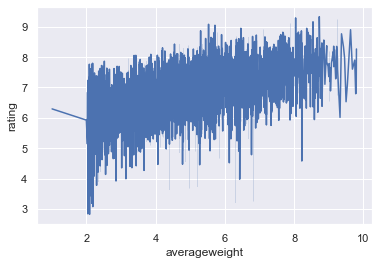

In [35]:
sns.set_theme(style="darkgrid")
sns.lineplot(x="averageweight", y="rating",
             data=rating_weight_comparison)

- This kind of line graph is more descriptive but harder to see, let's try something else:

In [36]:
rating_weight_comparison['bin_rating'] = pd.cut(rating_weight_comparison['rating'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=False)

In [37]:
rating_weight_comparison['bin_weight'] = pd.cut(rating_weight_comparison['averageweight'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=False)

<AxesSubplot:xlabel='bin_weight', ylabel='bin_rating'>

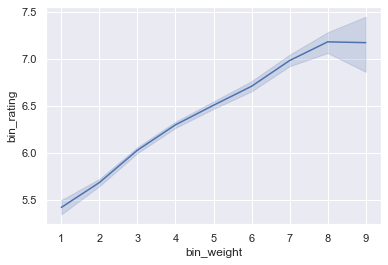

In [38]:
sns.lineplot(data=rating_weight_comparison, x="bin_weight", y="bin_rating")

- We can see that there is a trend going upwards, where the highest rated games are at least 5(In a scale out of 1-10 in difficulty). But something important to notice is that it seems to exist a risk-reward situation, in both ends (being too easy or too hard) that might also play a factor.

**We are going to make also a recommendation system based on the WEIGHT for basically two reasons:**
- Remove the bias - what is the best game for that person that has X weight.
- Provide a more personalized recommendation, the person decide how hard the game he/she is going to get, we are not always in the mood to play a super hard game and vice-versa.

### Filter based on weight to be made in the future 

In [38]:
# Here goes code 

### Let's get our data ready for our modeling

In [39]:
# Drop the column 'name' since we can use the ID and inplace=True so we keep our changes
bgg_reviews.drop(columns=['name'], inplace=True)

In [40]:
# We now drop the remaining NaN values that exist on the 0%, since having user is fundamental for our analysis
bgg_reviews.dropna(inplace=True)

In [41]:
# Sample of our data again to check how our data looks like
bgg_reviews.sample(3, random_state=22)

,user,rating,id
13907171,DeanMary,8.0,6137
147029,DarrylFerster,10.0,10630
13243091,Scubaroo,8.0,175695


In [42]:
# We use cat.codes to designate each user an unique ID
bgg_reviews['user'] = bgg_reviews['user'].astype('category').cat.codes

In [43]:
# We change the name of the columns to follow more of a pattern and be more descriptive
bgg_reviews.columns = ['user_id', 'rating', 'game_id']

In [44]:
# Now we have to rearrange the columns to a form that the model understand, that is:
cols = ['user_id', 'game_id', 'rating']
bgg_reviews = bgg_reviews[cols]

**Here we have our data ready to feed to whatever model we decide to use, but to make it lighter on the modeling we decide to use only a fraction of the whole data for now**:

The data is sorted by game, which we should pay attention to the way we will get the data so we keep a "healthy" ratio of number of users and items

In [45]:
"The number of board games is: {}, and {} of users".format(len(bgg_reviews['game_id'].unique()),
                                                           len(bgg_reviews['user_id'].unique()))

'The number of board games is: 19330, and 351048 of users'

The porportion is around 18 users for every 1 board game, so it is an item-item similarity situation.
Let's try to keep the same proportion.

In [46]:
bgg_reviews_subset = bgg_reviews.sample(1000000, random_state=22)

In [47]:
"The number of board games is: {}, and {} of users".format(len(bgg_reviews_subset['game_id'].unique()),
                                                           len(bgg_reviews_subset['user_id'].unique()))

'The number of board games is: 18893, and 189600 of users'

**That's a worse proportion - around 10 instead of 18, but let's move on.**

In [48]:
bgg_reviews_subset.head()

,user_id,game_id,rating
13907171,38098,6137,8.0
147029,36743,10630,10.0
13243091,139805,175695,8.0
15117025,73348,7097,6.0
15114494,319493,10915,7.0


In [49]:
bgg_reviews_subset['rating'].mean()

7.0547770227800015

In [50]:
bgg_reviews_subset[bgg_reviews_subset['game_id'] == 70323].mean()

user_id    177504.361844
game_id     70323.000000
rating          7.210681
dtype: float64

## For our modeling we try different approaches to find the best one:


We need to instatiate Reader to transform our dataset into a form that the library (Surprise) can read.

In [51]:
# We need to specify the range for the rating scale, since the default is 1 to 5
reader = Reader(rating_scale=(1,10))

- Neighborhood-Based

In [52]:
# We transform the dataset into a surprise-dataset
data = Dataset.load_from_df(bgg_reviews_subset, reader)

In [53]:
# We run train-test split on the data so we can validate it later
trainset, testset = train_test_split(data, test_size=0.25, random_state=22)

In [54]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  171595 

Number of items:  18440 



**We first try cosine similarity**

In [55]:
# Here we define that we want cosine similarity approach and set the user_based to false, since we have more users than items
sim_cos = {'name':'cosine', 'user_based':False}

In [56]:
# We set the model (KNN) and use the sim_cos defined before
basic = knns.KNNBasic(sim_options=sim_cos)
# We fit the model
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [57]:
# We get the predictions of our first model
predictions = basic.test(testset)

In [58]:
# And this is what it looks like one prediction
predictions[0]

Prediction(uid=241779, iid=4991, r_ui=7.0, est=9.0, details={'actual_k': 1, 'was_impossible': False})

In [59]:
# The accuracy that we are going to use is RMSE(root-mean-square error), but you can also use
# MAE(Mean Absolute Error) and FCP(Fraction of Concordant Pairs).
print(accuracy.rmse(predictions))

RMSE: 1.6322
1.6321928161994432


**Now we try pearson correlation**

In [60]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [61]:
print(accuracy.rmse(predictions))

RMSE: 1.6814
1.6813701984732634


It seems that cosine similarity is better for our situation, but lets try pearson with knn with means instead of the vanilla version:

In [62]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [63]:
print(accuracy.rmse(predictions))

RMSE: 1.5124
1.512350332149912


And now Pearson with Baseline:

In [64]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [65]:
print(accuracy.rmse(predictions))

RMSE: 1.4672
1.4671510425952061


This is the best result so far! But lets keep moving.

### We can also try Model-Based methods instead of Memory-Based

SVD is the most well-known algorithm

In [66]:
# We ran gridsearch to find these parameters - it's in the other notebook in this repository if you want to take a look
svd = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4, verbose=False)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.3732
1.373235884964243


- This is a great score, can be translated as 1.37 out of a 10.

### Lets see how our predictions actually work!

In [67]:
# What user 319493 thinks of game 1?
svd.predict(319493, 1)

Prediction(uid=319493, iid=1, r_ui=None, est=7.8178582355151045, details={'was_impossible': False})

In [68]:
# How about of game 70323?
svd.predict(319493, 70323)

Prediction(uid=319493, iid=70323, r_ui=None, est=7.6570807393458304, details={'was_impossible': False})

In [69]:
# Now a game that he actually voted for: 10915
svd.predict(319493, 10915)

Prediction(uid=319493, iid=10915, r_ui=None, est=6.964711812982833, details={'was_impossible': False})

> Close! We predicted a 6.96 and he actually voted a 7! (See on our table down there)

Making predictions for user 139805

In [70]:
# Now what user 139805 thinks of game 1?
svd.predict(139805, 1)

Prediction(uid=139805, iid=1, r_ui=None, est=7.9134411635271205, details={'was_impossible': False})

In [71]:
# And again game 70323.
svd.predict(139805, 70323)

Prediction(uid=139805, iid=70323, r_ui=None, est=7.739173249836734, details={'was_impossible': False})

In [72]:
# Now a game that he actually voted: 175695
svd.predict(139805, 175695)

Prediction(uid=139805, iid=175695, r_ui=None, est=7.521900942659941, details={'was_impossible': False})

> Not as close this time! A 7.54 meanwhile he voted a 7.

- As we can see our model is working great. Not only express how a user would feel about a game but also is really precise when try to guess a rating for a game that someone already voted for

In [73]:
# Table so we can compare the predictions with the actual values
bgg_reviews.sample(5, random_state=22)

,user_id,game_id,rating
13907171,38098,6137,8.0
147029,36743,10630,10.0
13243091,139805,175695,8.0
15117025,73348,7097,6.0
15114494,319493,10915,7.0


### Unbiased Accuracy Estimation

Here we try a different approach that uses validation and shuffle of the ratings to make the model more leakage-proof and have more of an unbiased estimation.
You can find the documentation here(https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation)

In [85]:
# We have our "data" assigned, we assign the raw_ratings, shuffle and then decide a threshold(85%-15% ratio)
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)
threshold = int(.85 * len(raw_ratings))

In [86]:
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [87]:
data.raw_ratings = A_raw_ratings

In [88]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

In [89]:
grid_search.fit(data)

In [90]:
algo = grid_search.best_estimator['rmse']

In [91]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [92]:
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 1.1242


1.1242098449179063

In [93]:
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 1.3675


1.3675329668557272

### Recommendation based on each user using collaborative filtering

In [95]:
def get_top_n(predictions, n=6):
    """
    Return the top-N recommendation for each user from a set of predictions.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [96]:
top_n = get_top_n(predictions)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

326757 [2651, 40834, 120677]
333165 [204583, 100901]
219844 [230802, 181404]
269350 [156129]
232789 [256226, 174926, 40692, 5716, 12589, 258437]
119438 [159675, 5]
317072 [54043, 216092, 478, 134726, 29581]
317208 [93, 15062, 635]
350212 [137408, 40381]
226076 [40834, 148740]
22884 [104162, 128218]
168201 [41]
302386 [102652, 150312]
29109 [29839, 478, 75091]
233441 [202426, 193738]
143231 [87890]
63662 [149776, 15062]
118434 [12333, 102794]
49507 [180511, 293, 123370]
307138 [12493, 198994, 27739]
91131 [73439]
274231 [478]
14473 [170216, 157917]
11953 [2651, 176494, 9674, 12870]
163219 [59946, 110868]
316959 [1927]
197022 [205059, 1338, 83667, 303, 97903, 482]
12558 [68448]
163810 [148228, 137014]
7316 [9209]
111557 [25669, 129622, 27225]
337887 [148228, 904, 9674, 168435, 71021]
272528 [115746, 124742, 214029, 222509, 146197, 27298]
91920 [174430, 203420]
264160 [31260]
139656 [110327]
47423 [31260, 172386, 81640, 39938, 280453, 198773]
283639 [171668, 136991]
204056 [822]
182295 [9

174328 [103885, 129622]
46581 [25584]
66467 [176189]
308374 [103092, 691, 5314]
232491 [3406, 155496, 7097, 159143, 27]
93431 [133038]
196797 [244228, 233955]
201725 [96848, 34707, 46, 102652, 116954, 6400]
277480 [136558, 68228]
79012 [9209, 146816, 206931]
330463 [463, 194655]
183691 [170042, 245934, 125618, 12692, 210663, 117942]
50822 [143884, 2633]
96571 [15062, 106217, 176396, 3085]
230734 [9441]
302986 [256952, 148949, 183251, 156009, 91514, 8195]
202289 [162009, 26990, 9215, 12942, 41100, 327]
143381 [192153, 41, 25821, 140951, 145012, 19989]
336355 [16267, 257]
18203 [2163, 10630, 12962]
127602 [156129, 6472]
205578 [11]
233086 [66188, 25643, 75091, 1198, 18866]
176447 [180974, 248158]
123199 [153938]
157479 [4390]
112802 [6249, 1502]
324942 [143884, 84454]
178065 [27680, 63888, 16747, 1803, 3201, 9220]
165721 [18]
53838 [822]
68625 [232832]
339116 [822]
206609 [69789, 16992]
235660 [268, 52, 436, 2936]
267587 [173346, 5451]
235481 [140934, 169436, 16986, 234190]
208902 [16288

50002 [256382, 161527, 166109, 8487, 258]
95453 [29256]
158732 [79127]
219032 [822, 21763, 65244]
151312 [244522]
160021 [173442, 85256]
13042 [177524]
226808 [184267, 124742, 143986]
184803 [194655, 144344, 45315, 228504, 204027, 236709]
52618 [124, 40692]
59802 [21441, 368]
282337 [38054, 171431, 160968, 4209, 137776, 29109]
12237 [6249]
159796 [233078, 760, 192291, 79828, 83197, 35570]
215173 [120677, 103343, 167513]
344181 [66056, 15512]
8688 [195421, 217372, 92415, 200954]
173251 [90419, 274960, 113289, 11705, 49]
316446 [157354]
191771 [68448, 15062, 24417, 141932]
256631 [39683, 135779, 76417, 45, 15889, 156]
309736 [174552]
186297 [31260]
299431 [244522, 22545, 27173, 269072]
242249 [169786, 155068, 192291, 175324]
43028 [9209]
9824 [110327, 21348, 100423]
282063 [193670, 22, 20133, 178613, 1772, 143884]
227885 [34635, 162082, 230080, 1379, 21892]
226543 [203993, 195539, 144041, 256570, 155987, 83330]
152208 [193738, 188920, 203416, 163967, 199223, 235696]
218830 [146204]
55150

284693 [1513]
240108 [28143]
152277 [21550]
156746 [162082, 93260, 144826, 148319, 199309, 21523]
114969 [28143, 134253]
39262 [120677, 69779, 172385, 144415, 47046, 119788]
5482 [166286, 191572, 204615, 181956]
319363 [2511]
184659 [54138, 30957, 88, 1897]
214944 [2651, 256916, 176494, 143175, 340, 166371]
97923 [194594]
207264 [161970, 181687]
181418 [22345]
199532 [173064, 932, 144529]
130631 [2968]
25040 [178900, 104006, 58624, 158275, 19329, 929]
163984 [25021, 4098, 17133, 30505, 153938, 826]
345841 [13]
21076 [233867, 2655]
228539 [1917]
287728 [102680, 45315, 128667, 29903]
11518 [8217, 91523, 133524, 116, 25224, 164159]
190840 [193738]
203382 [12333, 822]
142942 [192135, 188866]
141716 [122515, 266192, 116998, 66188, 41916, 11971]
67337 [170416, 215842]
238722 [2655]
227466 [200147]
113388 [145219, 179385, 144587, 181345, 91050]
199893 [3076, 49]
212130 [146652]
122689 [2243]
66127 [103, 24037, 23451]
79424 [201808]
94550 [59959]
101055 [27162, 172971]
64123 [154902]
171748 [1

41318 [252328, 282524, 242227]
102134 [172]
91522 [91, 31260]
329931 [109276, 72225, 94104, 23094, 122891, 144239]
326863 [110327, 128882, 19888]
178755 [104162, 128721, 171131, 124, 5255, 131568]
121430 [9209, 34635]
64422 [147949]
168826 [539]
36530 [198928]
184775 [237182, 24181, 152162, 36946, 5894]
317376 [463]
87613 [262215]
29645 [124361, 154825, 220877, 155426, 117915, 143404]
65292 [118410]
132143 [168584, 681]
260470 [128882]
258342 [178900]
225957 [40938, 339]
215178 [169786]
957 [121921]
109859 [194523, 73538]
4064 [287954, 224904, 91620]
38564 [172386]
213586 [19]
103834 [1159, 3139]
179332 [42]
10534 [224037, 203416]
318885 [133848]
64866 [163412, 126, 27588, 234190]
157270 [4168]
310079 [102794, 155426, 40834, 30381, 224, 5559]
3667 [521]
177274 [132531, 38657, 3737]
244241 [193738, 283948, 822]
187345 [251293]
31862 [148228, 67492, 136063]
119564 [9220]
295450 [2453, 203427]
48010 [117960]
283127 [197376]
340870 [119506, 72125, 65781, 212516, 145588, 54]
311307 [182028,

336163 [42, 2987, 43249, 4488, 25821, 24935]
285193 [822, 159503, 267370, 11971]
189601 [875, 1301]
76397 [25669]
314446 [236457, 104020]
55844 [36218, 105134, 168584]
146638 [123260, 92415, 1298]
267273 [125153, 77423, 157969, 192153, 169649]
153733 [170216, 131287, 83453, 9851, 1797]
168938 [85243]
158996 [205716]
83296 [281259, 206718, 153938]
303860 [140603]
80485 [120677, 155426, 31594, 43264, 22237, 443]
32746 [174430]
130273 [123260]
278945 [131366]
254749 [223855, 2653, 43570, 137031]
30773 [18833, 35435, 52276, 132372, 183441, 165404]
213249 [130674]
78299 [18602, 29663, 13362]
70563 [204027]
221851 [131646]
66551 [224517, 165722, 32441]
225452 [158435, 168788]
346800 [180263, 192135, 181304, 269207, 201825, 8817]
333471 [169786, 2181, 98778, 3737]
103014 [77423, 244099, 16699, 5432]
79379 [478]
205357 [66188, 1159]
90480 [233078]
317755 [169786]
204659 [203993, 63628, 92319, 165722, 235488]
300965 [218603, 153]
273812 [40769, 194880]
142191 [3439]
190576 [112686]
316538 [1247

4827 [21790, 787, 2598]
120990 [2651, 31260, 127023, 37111, 39683, 39938]
238301 [221194, 253470, 112, 116858]
98204 [228341, 160499]
43575 [230802, 69789, 123228]
293078 [11971, 27588, 700, 770]
344391 [96848, 173346]
30067 [68448, 15111, 8041]
173537 [77130, 34496]
118387 [48726]
91342 [39856]
297963 [180680]
13115 [42997, 1608, 432, 43152, 13004, 2266]
188423 [15953, 112, 2638, 10, 1412, 9203]
210204 [128882, 10547, 555]
310324 [39683]
219480 [183394, 182631, 209685, 233247, 92415, 15512]
52402 [207062, 220780]
210163 [8203]
276418 [171623, 39856]
263067 [1773]
4050 [108044]
250363 [237182, 269526, 25568, 27588]
325296 [144344, 258210]
210889 [85036]
225254 [37111, 209010, 155426, 166776]
234122 [126042, 12995]
107219 [555, 39938, 9341, 65568, 23329]
229179 [15062, 118063]
151630 [123540]
181192 [236457, 54307, 197409, 58329]
20755 [191189]
340823 [192834]
315239 [176189]
90063 [70323, 215311, 246761]
155416 [150658, 28023]
266751 [4209, 233149]
158133 [3931]
246301 [84876, 62219]
1

184899 [18602, 27833, 12477]
223155 [124742, 102680]
253755 [586, 43111, 43022]
33231 [30549, 159508, 256606, 42215, 131568, 2119]
79576 [158753]
203100 [174925]
221031 [46213, 2596]
190229 [31260, 24508, 88, 566, 2901]
303235 [98778]
265668 [124172]
170616 [149155, 1986]
111955 [118048, 173096, 256320, 183880, 223767, 91514]
220720 [1927]
118627 [39856]
11441 [28143]
217802 [1107]
67683 [30549, 181304]
126297 [20100, 133632, 91523, 161578]
324676 [118048, 43443, 163640]
326471 [13]
165226 [177678]
317428 [320]
55504 [157354]
273495 [3, 229414]
304861 [161936, 102794]
142940 [320]
260083 [220308, 28720]
232750 [34635, 207330, 116, 37120]
281879 [68448]
326026 [146508, 54, 109779]
21008 [124742, 203993, 18, 127060, 6481, 1917]
216820 [173346, 31999, 119432, 824, 172881, 6887]
133268 [115746, 205716, 183251, 62219, 244115, 3409]
307348 [183840]
336045 [244654, 2955, 244536]
306467 [36218, 104020, 155987, 31730, 183231, 22348]
345702 [180511, 31274]
253588 [9220, 2223]
30939 [100901]
2337

111246 [188930]
167753 [62227]
150665 [822, 136063]
191973 [119788]
343491 [40692]
318484 [28720]
89960 [62219]
143214 [2651, 40692, 127024]
123862 [822]
350861 [233078]
21103 [54998, 19857, 195137, 2392]
47793 [27071]
214717 [1632, 4174, 815, 1827]
187754 [40834, 225694, 148228, 2653]
132379 [157403]
10328 [244521]
233794 [2389]
164292 [30549, 3307, 7805]
278167 [2651, 30618, 1294, 74]
224831 [760]
224297 [84876, 4616]
15094 [93, 99770]
183487 [169255, 39351, 1465, 17223, 4491, 2223]
118968 [91514]
26720 [92828, 19237]
301422 [68448]
254479 [97842, 148575, 12942, 140863, 37196]
37198 [15062, 27588, 6795]
260475 [20432, 2842, 194, 1593]
212920 [164928]
265452 [36218]
4204 [244271, 170041]
290480 [31260, 58713]
138995 [188, 1690]
158766 [96188]
324530 [8203]
321634 [122515, 198773, 199561, 168435]
2626 [84876]
273707 [54998]
167412 [244795]
19104 [93, 242639, 23094]
239625 [134253, 71721, 225908]
184329 [193738]
37834 [187645]
136059 [91872, 20963, 24508, 11, 192673, 143986]
34605 [1294

240592 [43015, 30549]
143328 [174430, 30549]
185512 [69789]
228152 [209010, 263918, 256883]
298553 [139976]
232336 [200954, 541, 15364, 519, 38531, 4485]
53517 [68448]
294806 [18, 24480]
8348 [1043]
84077 [14105, 209418, 8217, 18460, 34819, 2223]
3048 [129622]
125003 [141572, 116]
316096 [15985]
108062 [45]
334415 [6552]
212268 [17635]
205097 [12263, 2932]
91090 [256623]
237964 [36946, 8522]
239047 [97903]
236737 [155426, 54138, 136888]
151375 [177639, 143741]
125085 [272739, 236457]
95725 [84876, 212346, 153938]
180420 [170624, 129622, 269069, 193739]
209423 [157354]
233918 [2653, 108784]
347542 [12194]
269850 [188834]
55712 [266192, 121921, 39463]
240541 [245638, 17133, 34119, 24480, 103, 28]
138739 [669]
160511 [248490, 233371]
31260 [70323]
305425 [2655]
321975 [822, 45]
15327 [39953, 180593, 180650]
309876 [2653]
54938 [184151]
132855 [180263, 110327]
228510 [77423]
6292 [276025, 2651]
286243 [82222, 34377]
80837 [9342]
138663 [72321]
122569 [172386, 181687]
4833 [12333, 2392]
232

165852 [30381, 50, 201, 4473]
264048 [127023, 24181, 70323, 267314]
350678 [139992]
295878 [236191]
130539 [228660, 94684]
339999 [209778, 184346]
218416 [27833, 172385]
273363 [13]
254528 [103885]
17710 [91536, 30658, 58936, 3228, 35503, 57925]
268233 [66589, 203427, 206169, 231280, 241831, 3837]
63721 [167791, 177639]
175163 [188, 6249, 13642, 8203]
63906 [121921]
343590 [13, 10630, 3406, 21790, 215463, 56933]
112722 [113924]
269724 [91536, 180852]
125915 [229218]
303934 [269210]
232739 [178900]
227017 [181810, 19624, 1927]
319685 [163412]
195712 [760]
132792 [191597, 31481]
114446 [48726, 129293]
298610 [187645, 195503, 594, 153064]
239917 [51]
228029 [100423, 2738, 144789, 165]
184394 [216132, 236457, 192291, 180974, 54, 147949]
67697 [172225]
109453 [191189]
195606 [12493]
204430 [12166, 180974, 279537, 256226, 215308, 34194]
48869 [31260]
214983 [230802, 129622, 40769, 150, 35761, 632]
61269 [11, 2405, 132]
65090 [262543]
59084 [320, 16398]
72789 [270844]
89616 [266810, 38862, 39

266065 [197376, 193912]
26736 [521, 128996]
57523 [3267, 1098, 7719]
112906 [229853, 240567, 41114]
259717 [169611, 2407]
37526 [96848]
233923 [39856, 822]
166169 [822, 112]
135821 [28720, 70149, 117915, 66505, 152162, 31503]
35594 [97786, 24508, 10814]
178981 [119391, 118023, 129614, 154003, 159507, 34185]
39700 [143519]
74697 [184151, 273264, 197097, 3955]
77167 [73439, 258210, 247236, 117914, 17240]
93320 [204583, 180809, 256067, 215312, 228234]
44661 [2539, 242, 16500, 3377]
69105 [22198]
218569 [154809, 147020, 50, 136280, 10206]
125688 [16992, 193161, 5894]
326817 [167400]
256064 [2655]
258761 [172]
223199 [14996, 21123]
247563 [124, 13308]
38773 [135382, 35306, 11, 161417, 4163, 93577]
323327 [224517, 177736, 242302, 70323, 103886, 128063]
65911 [20782]
241259 [859]
220659 [203993, 171623, 201808, 258036, 133038, 225818]
74415 [2651, 181304]
181581 [2381, 5259]
314670 [102794, 254640, 50750, 125618, 145659, 133632]
55876 [13676, 30166]
309994 [182116]
73244 [31260, 192836]
14878

58370 [215, 17329]
94656 [69552]
76440 [3720]
68039 [39463]
221583 [148949, 15510]
253594 [3267]
308063 [37904]
70652 [133038]
344900 [34635, 191051, 21241, 128927, 90305]
163432 [104710, 12902, 129622, 136585, 1865, 27363]
73444 [12493, 104162, 15062]
106100 [235655, 129090]
298421 [10547, 118705]
20432 [125618, 13507, 153097]
62448 [198994]
185863 [172542]
259159 [172242]
198989 [65244]
54033 [203416, 211485]
205505 [753]
328195 [283355, 199792]
102577 [174430]
50623 [241266, 134157]
214980 [93, 128698, 232918]
125111 [84876]
264886 [187645, 158600, 195539]
328633 [109276, 70323]
101771 [35677, 9220]
202881 [72125]
320772 [129731]
68219 [40692, 138788]
102248 [45]
282045 [63628, 242574, 230080, 62871]
52664 [208808, 130899]
121778 [104162, 20437, 156129, 65244, 327, 257759]
325404 [247436]
307184 [710]
221419 [174430, 15062, 203417]
201793 [137331]
76936 [161533]
131559 [192153, 8125]
58806 [21348, 65781, 449, 17162, 137, 590]
327017 [174430, 199478, 112, 27364, 42452]
258418 [209010

213870 [1927, 141430]
54980 [256570, 181687]
248617 [9216]
22980 [181236, 180746]
460 [65244]
316845 [6249, 214293]
32717 [127023]
240841 [14996, 130]
8751 [30549]
7873 [327]
294052 [154086, 38778]
70297 [110327]
300123 [2471]
343135 [36946, 1475]
112197 [126163, 4098, 108784, 8051, 38032, 71836]
214946 [187645, 24181, 4958, 987]
119841 [30957, 129622, 15600, 234691]
60726 [157354]
206422 [285265]
283881 [2655]
119522 [148228]
322596 [176524]
173584 [42452]
318111 [126163]
312035 [77423, 88827, 14996, 196496, 153728, 124622]
74162 [185343]
216123 [263918, 240980, 1234]
33096 [217372, 191301, 244946, 209001]
201853 [266192, 55600, 194626]
75774 [266192, 128621, 188834, 37046, 67185]
170993 [129437]
13682 [171668]
139506 [284083, 88594]
152995 [251247, 478, 217085]
259710 [146508, 166384]
148508 [253398]
60311 [157354, 103886, 1107]
50346 [3472]
314500 [4427, 22019]
23146 [54998, 2346, 31563]
84838 [232219, 638]
149602 [209685, 203420, 218603]
64853 [124708]
61362 [39856, 170041]
124141 

176041 [169275]
126089 [886, 540, 357, 256, 1463]
165993 [205896, 18, 247367, 262540, 132544, 180231]
208537 [171, 171499, 36946]
26489 [203993]
269780 [160499]
73335 [229220, 191862]
332318 [47, 143884, 66056]
336399 [173346, 14996, 235365, 172207, 155969, 142653]
277805 [95613]
180927 [18602]
220962 [8196]
236551 [195314]
252943 [254591, 113924]
18395 [170216]
289994 [216132, 172, 174660, 132817, 40832, 2944]
145970 [265]
12753 [176189, 122294, 17223]
216302 [182028]
130750 [70323, 73439, 699]
174621 [156129, 97207, 2397]
183148 [193738]
183958 [27588]
165605 [154301]
245020 [156689, 160477, 138431, 69789, 158339]
333078 [145659, 114387]
67607 [986, 147151, 632, 105593]
180891 [188]
72928 [148228]
54177 [136063]
202537 [236457, 27833, 116, 120515, 5432]
83723 [463]
22029 [264220, 221107, 226320, 65564, 210296, 171]
163700 [59959, 2653, 163602, 148575, 166384, 74]
47877 [730, 26457, 28857, 119, 49, 10653]
150678 [21241]
30155 [112, 137988, 8203, 171890, 201054, 7479]
312235 [178900]
2

255786 [34635, 229265, 24417, 39787, 470, 27848]
95034 [184921, 91312, 27848, 10293]
144944 [127023, 233867, 39463]
37814 [120677, 215]
283689 [72225, 181960, 327, 173090, 34599]
3714 [147]
236402 [193949, 132531, 34119, 18460]
72630 [14133, 9139]
297424 [22545, 13751, 156746, 72132, 23890]
27979 [163930]
137153 [36218]
156708 [408]
99993 [97207]
207600 [148951]
194639 [158600, 1269]
168734 [242667, 241829]
247699 [225694]
271731 [129622, 12995]
192452 [104006]
76827 [4583, 29294]
251729 [189932, 108745, 96026]
140039 [232219]
245631 [209685]
66924 [161936, 104006, 108745, 113401, 24396]
267681 [189932, 73439, 82421]
202178 [198190, 247980, 12747]
269800 [18602]
307725 [63628]
285477 [27833]
312347 [36218, 74]
282400 [240196]
320508 [9217, 10093]
256814 [163068, 118048, 156566]
164638 [65515]
120982 [39856, 21790]
20520 [77423]
334694 [2651, 73369, 233955]
341460 [5781, 8935, 1240, 20675]
266067 [172287, 193164]
46558 [65313]
292412 [203993]
188490 [9625, 2539, 13933]
224342 [22827, 90

278367 [181530, 15954]
199482 [98778]
263751 [50, 120906, 19643, 148261]
194638 [16395]
1225 [172308, 320]
268165 [12002, 2533, 38931, 34585]
258004 [27833]
22527 [120677, 15062, 29410, 82955, 348]
347760 [17329]
237239 [40692, 17025]
133838 [31481]
157972 [154825, 129622, 97273]
17941 [102794, 18833, 31627, 39927, 204, 16267]
180586 [153938, 42215]
25966 [40692]
20184 [40692, 15062, 50849]
141369 [146508, 93, 41863]
176966 [129437]
286208 [2651]
70162 [110277]
129028 [10, 36345]
287865 [170216, 209685, 40793]
181518 [124742, 119432, 9217, 117959, 57, 207010]
186816 [121921]
274093 [148228, 28023, 131260, 1269]
320310 [132018, 33665]
323714 [5404, 12902, 25224, 21754, 7682, 1410]
183075 [1496]
330077 [30549]
30585 [144592, 207691]
305565 [257726]
219704 [6472, 13, 244]
39484 [32944, 35052, 503, 257081]
190479 [14996]
130267 [14996, 70919, 131357, 1875]
196811 [157354, 192291, 131260, 117838, 30662, 71676]
151423 [183394, 117, 8989, 34599]
233709 [421, 686]
33298 [170216, 193042, 141572

95886 [248125, 10630, 136063, 1258]
232802 [144529, 156091, 137500, 56758, 102548, 46782]
240915 [36218, 1824]
275574 [205637, 215842]
172203 [272409]
118256 [2346, 1309]
187498 [173047, 143884]
113660 [234]
263370 [175973]
104366 [218603, 180040]
23088 [167791, 14105]
243563 [13]
217931 [16991]
69759 [68448, 212281, 171356, 100423]
182579 [163412, 48979, 224986]
159738 [167791]
134990 [259809, 30179]
225621 [236457, 172, 161417, 233955, 24509]
350079 [42452]
268425 [230802, 93260, 223953, 197320, 25758, 35935]
123622 [181293, 39206]
26889 [13]
135146 [9220]
200773 [191977, 143401, 31920]
241209 [5923]
105949 [209530, 172008]
119353 [24480, 15, 63759]
196789 [244331, 194505]
299044 [10998, 2625, 8502]
342371 [42487]
5947 [173018]
180139 [161970]
33829 [157969]
5305 [8098]
196563 [6249, 28259]
121199 [124742]
71860 [104162]
95135 [3955, 157789]
225131 [104006, 8098]
99952 [132531, 270970, 42487, 25669]
126770 [218417, 174570]
94776 [10547]
285141 [58936, 40628, 17449]
350563 [37696]
202

280336 [31481, 170587]
15411 [225694]
121037 [70919]
139005 [182028]
325943 [203993, 194655]
289315 [1927]
227824 [8958, 4553]
259527 [40692, 3931, 3071]
238934 [699, 54, 22085, 3484]
167830 [9823]
341595 [35677, 65673]
335597 [20100, 12577, 815, 633]
274349 [46213]
163398 [198138]
12515 [171131]
221683 [80935, 58329]
170396 [8203, 79282]
281699 [250458]
347886 [104162]
180562 [18258]
161835 [233868]
90456 [201825]
104667 [31016]
242756 [180263, 97207, 132372, 102898, 61, 27940]
49491 [31481, 71721, 29678]
1721 [96848, 167400]
228331 [198773]
242462 [242302, 19857, 13]
121161 [37046, 140620]
161685 [58421, 40692]
36210 [24068]
25520 [121, 26990, 39856]
259499 [34635]
294347 [84876]
147861 [1568]
159544 [86415]
153891 [18, 25669]
175945 [178900, 63268]
9022 [42, 171356, 181796, 103328]
131702 [131357]
115120 [192153]
334752 [29934]
168996 [284435, 159406, 25261]
236539 [14996, 174614]
183535 [143519, 103343, 21809, 208895, 1515]
156509 [10]
90297 [191972]
216112 [904]
317069 [170042, 12

107974 [156566, 154906]
290731 [155068, 193558, 71671, 150293, 181761]
342820 [171]
45435 [8170]
6175 [25277]
207362 [40692]
97619 [167355, 146508, 205637, 209324]
305904 [193670]
335940 [201808]
46526 [6817]
169931 [194655]
206316 [163412, 262215, 178900]
343294 [478]
286164 [129437]
62033 [31260, 521, 176920, 11, 1917]
124276 [170216]
223999 [171623, 144733]
330560 [34635, 33604, 634, 1270]
207275 [29603]
65515 [173346, 249, 35248]
133617 [9209, 34635, 31260]
332505 [70149, 154203]
195500 [192153]
191062 [200680]
255095 [11, 143884, 35812]
243367 [475]
60623 [180899, 232043]
345458 [28720]
304474 [11170, 6472, 119391]
224053 [3040]
225182 [129622]
64433 [63888, 128671, 172503, 156009, 12761, 1111]
48225 [124361, 182874]
288952 [320]
285754 [9209, 194607, 12002, 113401]
263879 [195162, 197865]
330936 [6205, 6860, 6504, 420]
327721 [19777, 147020, 171668, 949]
205697 [58110]
299320 [103885]
68454 [237087, 43443]
89476 [13751, 28]
64415 [463]
251311 [760, 27588]
300922 [15512, 220780]
1

297145 [6607]
339413 [148228]
344859 [198928]
110817 [98778, 131357]
311113 [200057]
282435 [929, 1465, 74]
185431 [37111, 186323]
324813 [28143]
16386 [198994]
178225 [12995]
260928 [2651]
299364 [12350, 5404]
276775 [171, 4143]
47001 [223750, 143459]
279330 [113294, 43570]
189995 [204583]
200436 [148228]
322169 [24773, 16992]
245562 [169426, 180816]
286624 [822]
304016 [158899]
146693 [91080]
183144 [174430, 40765]
137686 [121921, 258036, 4324]
144162 [1576]
14803 [147020]
34952 [12002]
198746 [1917]
185828 [91872]
285732 [104006]
283803 [1198]
155197 [266192]
327824 [154203]
268483 [20963, 99120]
191349 [150376]
348150 [160851]
120937 [40692]
326403 [133473, 2653, 941]
18698 [14996, 65244]
190435 [157354]
286806 [4583]
299316 [85256, 125, 148951, 1602]
342395 [31260, 30549]
16293 [256788, 158600, 227456, 248900, 176396]
100018 [257]
323511 [228341]
254315 [6767]
193822 [28143]
18756 [66171, 132]
75626 [102680, 196340]
158228 [164153]
167534 [127060, 27173, 66171]
197026 [31730, 9231

226448 [15985]
186709 [42, 9209, 27588, 438]
346794 [39856]
321106 [149155]
266887 [42, 36218]
233077 [177590, 178336, 503, 40628]
166271 [148228]
161480 [181304]
190041 [253215, 12962, 13005, 219509, 2146]
93626 [3]
180789 [17449]
279596 [209685]
303935 [14996, 21441]
337124 [822, 712, 176494]
342623 [157354, 151007]
237699 [84876, 120677, 36218, 40692]
230631 [37904]
215023 [1499]
135848 [9209]
333314 [266192]
193660 [154203, 43570]
244548 [31759]
256872 [133848]
164627 [63628]
324808 [36218, 176494, 394]
221735 [40692, 158899]
66614 [243, 1372]
301900 [2651, 198928, 172220, 171669, 112686]
203295 [140]
161107 [70323, 264055, 207062]
265943 [258413, 249821]
212199 [9441]
246158 [13]
338117 [50381]
283052 [24480, 25568, 903, 3234, 3921, 170]
244371 [177939]
348793 [154086, 251420]
164518 [126996, 74]
309779 [16992]
175665 [110327]
5860 [59946]
248255 [223953, 254018, 904, 28259, 7475]
41340 [1634, 112686, 1294]
48881 [20133]
123635 [124361, 205398]
33994 [13]
347095 [172386, 131357]
1

122427 [279, 5432]
286093 [24773, 105037]
46700 [4636]
114017 [70323]
53196 [54137]
174006 [83040]
219049 [140620]
37422 [31481, 37111]
301971 [1331]
268474 [39856]
25990 [100901]
272358 [38453, 55158, 101785, 33196, 29387]
324586 [108745, 822, 10291, 11635, 3586, 11231]
123884 [8217]
89172 [169786, 8217, 136063, 123540]
219771 [2653]
303257 [1406]
41285 [199792]
168019 [103343]
332390 [131357, 545]
81259 [204583]
52865 [53953]
81591 [110277]
282240 [110327]
179032 [10, 6554]
64515 [180020]
242840 [269207, 165986]
255016 [46213]
66011 [239188]
270085 [39217, 37046, 13875]
219051 [9209]
835 [35614]
26935 [132531, 2593]
77628 [36218]
203976 [10630]
350989 [204184, 131014, 47185, 1406]
128987 [155873]
278200 [130486, 171668]
22531 [168435]
93239 [176189, 9209]
225397 [92828]
139849 [34635]
28605 [27173]
79448 [71836]
339901 [148228]
162527 [204583, 105551, 127398, 278]
119813 [169124]
323301 [9801]
278680 [478]
35509 [431]
214476 [197865]
194566 [30869]
266501 [6044, 1536]
148530 [1294]
2

212058 [16992]
252819 [98, 1917]
269442 [157969]
158452 [176734, 139952]
32583 [126163, 146439, 1041, 9220, 147790]
242559 [33665, 193238, 5956]
31871 [14996]
302443 [760, 84]
226436 [42052, 1559]
217928 [133473, 131357]
100502 [176165, 94362, 231991]
49139 [139976, 19348, 878, 143884, 761, 162]
285121 [177736, 12]
263026 [97903]
288951 [140603]
317215 [216092]
32505 [3040]
179999 [169124]
288777 [148228]
255990 [432, 17735, 1117, 22278]
344948 [190639]
49337 [163602]
35636 [103885]
333516 [2136]
266329 [100423]
288857 [34969]
276482 [22545]
230373 [118048, 822, 9440]
300567 [160851, 34887]
216348 [180263, 7967, 11415]
126418 [66188]
176749 [40692, 19100]
609 [143741, 69552]
34227 [8502]
154054 [147949]
332586 [49]
339061 [72125]
315942 [6779]
193774 [36218]
14348 [195372, 136280, 73369, 169654, 63975, 10]
216856 [125618]
268521 [136063, 175117, 174614]
174063 [54998]
42786 [14736]
326457 [12333, 124361, 104581]
221785 [14254]
210776 [21348]
126038 [236457, 157969]
264274 [154003]
1271

164635 [266524, 136063]
39627 [265736]
236963 [148228]
334736 [217449]
153387 [503]
58069 [28720, 243, 144733, 54043]
90073 [172818]
108046 [237706, 178336]
135125 [1425]
186888 [2181]
140416 [70323]
291121 [172081]
29641 [8098]
300884 [133038, 147, 11081, 119, 69552]
152320 [35677, 13]
119629 [31274, 121410]
210557 [16992, 2407, 5432]
97281 [902, 111327, 63740]
255768 [224037, 226518, 244228]
310045 [22545]
333583 [320]
49296 [36399, 12902]
13642 [50]
285077 [233867, 233312, 168788, 72287]
97222 [15512]
31652 [196326, 34585]
131937 [124]
329129 [1404]
314442 [150376, 48726, 30539]
101695 [30549]
296333 [2266]
222109 [12942]
219696 [40531]
284582 [124708]
163367 [236457, 147151]
248619 [527, 33154]
214854 [229853]
253727 [232666]
238397 [13, 129622]
80593 [36218]
176142 [11161]
177565 [133038]
107052 [187645, 176920]
174222 [15987, 110277]
209098 [548, 4122]
158610 [1258]
156481 [169786]
65147 [243, 4098, 17396, 30380, 21763]
148292 [22345, 43528, 2047, 210]
163644 [63628, 40692]
22073

133508 [675, 15818]
105670 [162886, 37904]
123464 [27588, 153723]
185982 [167791, 133473]
73268 [135262]
25218 [247763, 171131, 206327, 171, 5314]
122215 [54138, 118048]
169056 [15062, 121073]
283432 [92828]
193637 [37904]
25099 [131014, 478]
276549 [217398]
155474 [8217]
59808 [46]
228107 [2653, 250878, 624]
129300 [21241, 76674]
348400 [154809]
291404 [257]
149879 [50]
53149 [10547]
266788 [70919]
11221 [90137]
112240 [13728, 7719]
250335 [198773]
243320 [256606, 4122, 2392]
277852 [264220, 150376]
168324 [166317, 12942]
52130 [39463]
79434 [84876, 133473]
280920 [176494]
81224 [175199, 12942, 171233]
152733 [150376]
154993 [31594]
195102 [72448]
238231 [247763]
183928 [167791]
303757 [164928, 54625, 55670, 24508, 8217]
214716 [150376, 50]
188801 [246192]
149787 [36218]
51092 [2452]
22914 [3076]
154017 [12, 30549]
24550 [104162, 11170, 195314, 88]
171144 [9028, 1406]
222121 [179275]
224352 [39463]
103124 [15, 752, 929, 380]
214606 [72125, 50, 113924]
312524 [105]
98771 [162886]
20712

134833 [221194]
28114 [167270, 133473, 181304]
112395 [96848]
300975 [5737]
77778 [21523, 4390]
59092 [8989, 1324]
32611 [202408]
101709 [96848, 2397]
281230 [36218, 116]
209961 [22825]
203183 [14996, 6068]
118028 [21241]
204388 [25114]
112411 [93185]
282744 [129622]
301956 [205059, 216132, 150376, 34635, 28023]
295934 [822]
176668 [77423]
144683 [29687]
251794 [2407]
201437 [168537]
230612 [121410]
101547 [31481, 36345]
292237 [166857, 149155, 67910]
16543 [112686]
265382 [124708, 107529]
290513 [126163]
31789 [1188, 39953]
107716 [233867, 108745]
141140 [142079]
109994 [226588]
191749 [178900, 2998]
163671 [186701]
230704 [204837]
297528 [805]
203786 [129622]
8388 [70919, 143405]
95346 [36218]
222934 [231450]
123445 [5432]
90251 [32048]
207270 [68448, 40432]
195509 [113924, 205418]
86425 [183394]
106528 [84159]
186512 [144735]
151930 [1334, 16373, 28025]
1852 [120906]
84133 [148949]
82748 [822]
21006 [23730, 192]
61400 [237182, 244433]
193938 [40508]
232730 [68448, 165948, 136063]
33

220208 [65244]
348481 [169426, 223040]
142989 [9440, 12995]
262580 [281259]
198803 [7204]
202943 [46213, 2386]
338254 [178900]
283993 [230802, 43015, 136888, 54, 38872, 125]
219288 [127023, 98778, 172552]
252452 [163412]
112351 [250458, 156336]
281849 [43015, 25643]
231110 [1431]
227778 [120677]
263801 [192135]
319245 [143515, 39328]
335613 [129622]
322482 [256960, 164928]
336877 [92828]
323305 [176189, 70323]
192808 [164153, 17710]
332397 [2655, 21791]
108633 [254193]
111522 [30549]
175146 [198994]
320909 [2346, 175199, 20090]
2951 [104710]
276604 [191597]
343446 [136063]
66177 [164153]
208547 [171835]
268958 [178900]
34551 [6472]
29296 [90419, 478]
276988 [114871]
60813 [36218, 27833, 121410]
150584 [18602, 181]
328058 [219100]
179427 [151004, 195571]
96000 [178900]
290214 [183394]
308921 [161936, 169786, 256382, 147151]
264636 [125]
203571 [147020]
232402 [204184]
325707 [2375]
170475 [2065, 32901]
231820 [31260]
46070 [34635, 6466, 31274, 16267]
55166 [177736, 254640]
276622 [25699

215672 [150138]
253421 [2633]
55259 [177590]
96401 [131835]
80745 [155969, 142262]
331189 [827, 1262, 1419]
152022 [120677, 33160]
83779 [90137]
98365 [167791, 1540]
33260 [172242]
268305 [7866]
39337 [147930]
44059 [39463]
201355 [463, 121288, 478]
185779 [121921, 770]
140925 [25021, 80006, 1198]
189790 [25613]
333921 [108831]
51085 [15062, 105]
34813 [36218, 24417, 8946]
207622 [191189]
316307 [13]
146469 [13, 123096]
221264 [22192]
195598 [231035]
323611 [36218, 9440, 635]
1592 [85897]
104985 [119337]
193571 [77423, 25554, 119591]
304356 [2651]
62630 [169786, 164928, 172225]
285027 [232219]
205813 [218637]
127060 [15363]
4087 [257614, 12624, 271055, 5839, 195518]
148868 [150376, 124361]
75092 [36218]
51975 [32674]
230495 [182028, 25669]
25357 [7717]
318696 [62222, 864]
174492 [226522, 22808]
192391 [40692]
238970 [4390]
258684 [157969]
338818 [299121, 133689]
277361 [129622, 223040, 244049, 267319, 281960]
99726 [167791]
244877 [478, 171, 127024]
217560 [181304]
350636 [171623, 1536

37190 [91, 68448, 3]
234206 [22038]
287404 [8098]
89743 [13767, 15047]
78200 [3685]
321939 [264241, 232918, 158340]
329394 [68425, 63888, 31481]
257803 [2386]
226753 [144553]
259313 [171630]
178462 [18746]
7204 [256382]
57105 [137269]
265911 [260428]
154539 [19857]
19837 [2338]
22886 [279869]
192629 [2651, 2495, 1117]
169189 [41326]
242114 [27162, 33071]
334761 [2651]
170602 [163602]
281067 [1442]
132159 [91312, 172225]
270671 [17958]
324958 [27588]
306311 [143693, 123260, 176494]
39245 [162009, 822]
313137 [104020, 113293, 19466, 170]
107021 [5894]
90458 [25900, 7955]
209340 [3577]
346884 [237182, 166669, 179933]
262798 [63888, 21441, 156496]
44810 [150145, 8129, 217335, 68247, 107529, 8203]
213505 [178900]
216696 [28259]
31318 [137500, 32014]
96993 [121288]
184708 [5966]
251998 [182874]
186075 [173346, 108745, 127398, 21763]
171690 [478]
34476 [102652]
334715 [9209]
58732 [291457, 235802, 182874, 171131, 160851, 182351]
131754 [199561]
214760 [161970]
306071 [1829]
6649 [178900]
2562

129148 [138161]
273483 [2651]
121314 [86542, 183472]
220212 [175640, 40765, 194553]
174962 [9625, 136888, 372, 161108]
174239 [96848]
171487 [125921]
26735 [1561, 12672]
1602 [167763, 158339]
58918 [3353, 9203, 27048]
158229 [176494, 254617]
328721 [183880]
63777 [19857]
178914 [521]
199793 [2375]
174766 [42898]
220722 [191231, 55601, 21704]
158966 [129622]
217101 [102794, 129622]
61923 [84876]
57824 [171]
183379 [132531, 118174, 109932]
133773 [133632, 943, 607, 2719]
268315 [54043, 37696]
161862 [1406]
104814 [187353]
89063 [136056, 20545]
175669 [155362]
315505 [22545, 269207, 113301, 172584]
303836 [124361, 875, 30645]
83006 [143693, 173101, 266967, 7804, 24509]
128632 [260635]
296677 [2093, 121408]
19357 [28023]
24703 [63888, 100423]
203072 [74]
233398 [182028, 181304]
283941 [210290, 186995]
221006 [37111]
148738 [217085]
132458 [72125, 30539]
4891 [227789, 258244]
109681 [150376, 111069, 32125]
232612 [2603, 10653]
4004 [175640, 229265]
40826 [142854, 10152]
221087 [221107, 1634

207359 [188834]
236899 [478]
60228 [124390]
155457 [34635, 4396]
154456 [14996, 30367, 1269]
89452 [24742]
322006 [173346, 54043, 760]
198554 [144529]
5101 [18602]
215087 [118063, 1927]
196257 [35677, 199561]
232503 [237]
130362 [244521, 129051, 192934]
160471 [31808]
309431 [183006, 201]
155754 [9440]
43605 [35677]
269177 [70323, 136063, 175621]
248456 [187645, 14996]
183120 [122522]
305846 [272453, 244918, 166509]
255091 [35635]
114644 [151347, 181521, 174660]
49429 [182028, 96848]
53416 [236370]
96395 [481]
193092 [555]
178167 [217609]
16446 [141, 27710]
333984 [555, 31481, 1212, 2297]
291265 [2322]
24270 [22545, 262712, 30380, 878]
313082 [113294]
84771 [72125, 31481]
76023 [13, 129622]
94878 [7]
288653 [250458, 166226, 34084]
257652 [24480]
259145 [12333, 27225]
96220 [70919]
310725 [1032]
155845 [178900]
192893 [1198]
343705 [10547, 226631]
220733 [131357]
322822 [157969]
31079 [39953]
48501 [132531, 206718]
206519 [205059, 1406]
234131 [224597, 239188, 43528, 69120]
272259 [3567

121620 [257058]
262305 [201921]
250644 [13004]
350747 [102680]
141207 [125977]
74273 [198994, 203427]
119611 [180593]
250187 [244521]
280152 [155426, 172242, 1294]
258722 [36218, 34635, 320]
228963 [27826]
58984 [185343]
224654 [169786]
236320 [32412, 22889]
165874 [9209]
138130 [157354]
327500 [181810]
245993 [59294, 160499]
311092 [139899, 20100]
250272 [167791]
313806 [199561]
267431 [146021, 206718]
262130 [125311]
207960 [15987]
51961 [41863, 24703]
247219 [11]
133690 [146312, 269752]
70437 [160010, 182134, 158163]
172864 [34496]
184630 [68448]
186806 [15987, 50750, 119591, 714]
7255 [128882]
14541 [95527, 90419, 1345, 43152]
233573 [11]
208120 [31563, 126792]
309236 [169786]
60872 [235362]
92970 [43041]
281822 [230802]
64751 [126163]
308484 [125678]
262912 [18602, 398, 2326, 1597]
207224 [214880]
154915 [85005]
27734 [100901]
182143 [232043]
26047 [253379]
121141 [8098]
118763 [177736, 72125, 1261, 2288, 17161, 1435]
266592 [35677]
340827 [144733]
295245 [63888]
8707 [33732]
1506

30303 [174430]
60306 [150485, 3522]
43446 [209010]
73411 [163068, 9209, 90137, 692]
242572 [171]
46577 [130960]
185747 [157969]
304904 [28143, 156336, 9674]
10531 [124490, 54735]
186732 [17226]
243545 [147949]
102241 [50, 24509]
288545 [3699]
61959 [5455]
317740 [13, 3595]
296603 [183840]
83420 [127398]
75427 [92415]
132544 [9209]
192078 [104377]
8723 [147020, 31481]
184544 [10630]
194939 [38984]
203365 [147930]
9589 [35505]
31254 [100901, 154642]
89025 [98778]
197138 [124361]
292152 [164153, 69789]
329804 [36218, 42490]
261939 [22545, 58936, 30957, 54, 146388, 173090]
336339 [35677, 42111]
165498 [3, 50, 1376]
307820 [92415]
290015 [41114, 9217]
254770 [202670]
272895 [21763, 41010, 147370]
315853 [3076, 128882]
277474 [68448]
340209 [244049]
37889 [43015, 193558, 701, 158100, 11182]
167111 [164153]
235409 [190232]
6399 [86955]
222277 [166669]
222344 [124361, 244521, 200847]
335240 [4336]
273760 [234487, 232219, 62871]
165173 [1563, 2821, 36739]
44402 [158899, 112686]
144009 [92666]
5

28805 [30957, 134453]
316584 [258074]
315409 [230802]
6446 [13]
181875 [42215, 125028, 1927]
168231 [14996]
135278 [54043, 58110]
281535 [45315, 50, 145639, 55697, 2582]
213884 [40692]
241638 [92828]
334801 [159566]
251479 [155987, 148575]
65616 [230802, 124839, 154906, 7804]
42346 [13, 594]
72811 [150376]
130062 [1294]
117930 [233078, 10547]
2143 [203420]
141462 [237182]
167330 [1465]
266184 [92319]
313001 [14996]
104844 [10707]
158129 [10547]
284039 [251420]
119748 [229853]
240369 [24480, 163937]
124567 [139976]
49542 [21763]
34787 [27746, 66510]
287731 [266810]
179923 [124742]
5831 [172225]
205347 [70919]
163515 [73664]
233564 [158600]
338274 [77423, 137290]
337258 [3307]
109482 [35677]
327955 [196340, 66587]
190481 [129622, 12942]
205023 [23, 135840]
105798 [283355]
92011 [173346, 98778]
337702 [159503, 17851]
324363 [70323]
164768 [11]
6523 [140524]
296420 [31260, 183394, 132531, 204583, 172225]
32971 [298690]
12519 [199561]
32572 [9209]
300225 [65244]
344541 [71721, 9161, 16398]


299883 [14996]
182798 [102881]
312439 [185343, 176189, 194655, 140934, 172818, 168054]
240547 [73439]
58179 [272453]
94302 [438]
187186 [20100, 147949]
231086 [143703]
93193 [54043]
128492 [131357]
4200 [17250]
175729 [3137]
264667 [40765, 119890, 131357, 7805, 15818, 91536]
227727 [129622]
257914 [199042]
332234 [3720]
193903 [29839]
335849 [181687]
147206 [822]
314575 [3076]
290482 [17922]
329583 [121921, 478]
87576 [62227, 1234]
161892 [21241]
114154 [811, 257, 258]
205413 [1294]
215411 [40692, 40398]
92556 [71906, 33154]
52191 [2081, 20963, 626]
55393 [128667]
89694 [68448, 72287]
131091 [30549, 100423]
302665 [172287]
151640 [247763, 221194]
160475 [203420, 46213, 46743, 2593]
80235 [274037]
227276 [31260, 24693]
306329 [14996, 42215]
3953 [176494]
178830 [9209]
258463 [298065, 159503, 233961, 269526, 302260]
45748 [2223]
82350 [198454, 46, 231696]
130215 [40398]
9729 [236457, 206931, 285171]
259475 [127994]
318337 [253499]
295815 [271896]
87518 [84876]
322338 [40692, 131357]
5821

180059 [248584]
226893 [42776, 148228]
167018 [125678]
167896 [170216]
10805 [478]
296944 [1797]
67333 [164928]
134503 [478, 24508]
304845 [18]
68920 [224783]
107123 [178900]
207325 [118418, 171672]
146753 [148228]
216173 [150145, 148083]
124972 [11]
168277 [127398, 478]
143366 [20100]
91068 [9609]
144445 [115746, 169255]
47809 [177524]
149575 [196326]
108868 [176606]
342564 [72125, 140603, 148949, 40765, 209716]
238226 [192283]
314573 [163967]
348592 [171623]
91772 [285774]
213303 [57163]
275655 [58110, 218519]
215150 [102794]
222325 [124742, 143075]
108792 [100423]
221197 [192291, 111417]
168623 [205059]
121929 [148951]
54036 [161417]
281387 [175117, 19996]
177638 [151247]
198108 [28143]
60662 [192153]
324868 [2471]
299844 [33967]
115387 [2651, 266164]
255668 [54043, 181304]
337936 [174430, 122515, 244522, 247360]
333106 [13]
73257 [73439, 9609, 150999, 168, 13751]
163277 [266192, 146652, 263918]
307529 [194655, 11634]
176682 [122515, 194594]
238757 [113401, 31016]
54658 [1353]
17398

226405 [42215]
320653 [41189, 122522, 43443]
38725 [161936]
176508 [122515]
178691 [12333]
242199 [205896, 207830]
344881 [68448]
307586 [204583, 9938]
39727 [30539]
316340 [124742, 70512, 8217]
47000 [236457]
280083 [131357]
9894 [117959]
306232 [11229]
27257 [20963, 22347, 40350, 17709]
200767 [174430]
156350 [54043, 70919]
260206 [246784]
125631 [822, 5758]
155476 [180974]
193025 [188834, 1406]
114144 [15363, 143884]
39183 [43111]
249278 [232832, 126163]
212235 [5782]
40067 [822]
154236 [256226]
157473 [1597, 38359]
134741 [287954]
169634 [3076]
330504 [127024]
276488 [170437]
14853 [169102, 150783, 69785]
353 [278, 28246, 539]
29249 [75789]
122957 [160419]
1739 [68425]
331399 [183394, 161970, 221318, 42452, 266771]
139155 [194655]
335501 [2655]
51076 [66589, 281417]
179401 [14996]
136557 [167791]
302390 [224597]
308689 [21790]
272434 [39856]
3638 [136494]
74164 [176494]
16063 [175914, 4098, 206754]
292205 [31545, 41, 720]
347148 [1499]
145186 [221107, 105134]
79035 [183394]
8654 [6

245984 [42111]
4348 [140934]
174794 [176189]
310961 [3421, 380, 590]
26321 [25292, 103886, 54]
311415 [174430]
116165 [172006]
111057 [3495]
203171 [148951]
321657 [19600, 44163]
260158 [29073, 5014]
110003 [128664, 136587]
55624 [71721, 101785]
110880 [209685]
165643 [15817, 6249, 9346, 714, 15180]
239654 [9446]
78375 [71721]
227217 [176396, 8203, 171037]
32890 [5]
328150 [131835]
263323 [16992]
240562 [68448, 2471]
133852 [2795]
116241 [83330, 140933, 631, 101785, 103651, 16366]
232624 [74]
65123 [106753]
239410 [30549, 123260]
138428 [136056]
298475 [262712, 158600]
151021 [192291]
39003 [265736]
28211 [3439]
100702 [67026]
323595 [161882, 37734, 12942]
302736 [83196]
148600 [237182]
75161 [156009]
115455 [4077]
11076 [207753]
229814 [58281]
87181 [220308]
5992 [27746, 70919]
254358 [35054, 19027]
302714 [1711]
45559 [266524, 180602, 175961]
16213 [30549]
305780 [113924]
224510 [103885]
16539 [935, 2541, 6351]
93186 [30380]
122404 [124361, 264241, 137480, 93997]
199300 [173346]
2364

15266 [167791]
339492 [7708]
68344 [163412, 13, 168435, 1917]
150680 [27627]
120117 [157969]
274407 [171623, 224037]
291086 [237182, 128698]
194055 [70919]
144897 [41]
200028 [10547]
194314 [12493, 110327, 1345]
285641 [70323]
293613 [3955]
306378 [40834, 1297]
236403 [173346]
299664 [164153, 70919]
306518 [106]
330447 [14808]
35763 [175640]
204978 [178900]
120073 [157958]
172151 [237182]
228550 [146021]
156094 [147020, 291508]
258763 [197376]
242675 [185709]
45104 [39856]
174866 [438]
10256 [1604]
323144 [65244]
47905 [150376]
146711 [151022, 179275]
286630 [182874, 54307]
272642 [205359]
71135 [245654]
205761 [230383]
155883 [28143]
159370 [7634]
334780 [2331]
130463 [170771]
230345 [191862]
54340 [77423]
77300 [174430]
211441 [2471]
163990 [201808]
261170 [72125, 112138]
275052 [209685]
124024 [79127]
23751 [147949]
91918 [205185, 157789]
261606 [167791, 183231, 97786, 170146]
159055 [70323]
321586 [3685, 3518]
348132 [12493, 84876, 83330]
255491 [124742, 10630]
18972 [194655]
26790

15218 [131357]
347781 [161970, 178900]
52551 [3076]
163206 [133473, 131835]
302722 [2651, 143884]
100535 [13, 34297]
39486 [136063, 245446]
276747 [175199]
121733 [214032, 244992]
214405 [238182, 201921]
6756 [166384]
177109 [148203]
60202 [227888]
196566 [128271]
214601 [50]
291840 [170042, 179172, 494]
310068 [36218]
105922 [217]
305594 [372]
58670 [31260]
51251 [67877]
343904 [162886]
238342 [2448]
191768 [14105]
100531 [146508]
236516 [167791]
169790 [95234]
306714 [15987]
192264 [54998, 33581]
234304 [84876]
268415 [129622]
296101 [91872, 94731]
196559 [3931]
151180 [161970]
50009 [194607, 68182, 137297]
217202 [206150, 230650]
338361 [204583]
290560 [1111]
42385 [1234]
282123 [178939]
196951 [160477]
309015 [10392, 6022]
109030 [25234, 22141, 3676]
14257 [202589]
212295 [183006, 15363, 234396, 149809]
350262 [112991]
38612 [172242]
122155 [171672]
93166 [13]
311051 [157354, 13]
279062 [478, 63888]
310670 [5782, 121297]
62896 [114031]
43040 [12493]
20741 [236457, 6249, 96913]
3279

327497 [144344]
159149 [829]
271847 [11]
260515 [2653, 117959, 173090]
349552 [12333]
304336 [40398]
288525 [68227, 125921]
272635 [68448]
228044 [142326]
63881 [5072, 384]
78205 [3567, 483, 1297]
113109 [2223]
339894 [123885]
136452 [163602]
288357 [82222]
332968 [33604]
44808 [204583, 230746]
13909 [4143]
209105 [16747]
26282 [132531]
307397 [2651]
252918 [35677, 146579]
153187 [233398]
31867 [39463]
254389 [96848]
68459 [150658, 158275, 160851]
79965 [155987]
140394 [180564]
184779 [24]
147110 [121921]
134629 [178302]
124792 [150364, 27674]
200208 [42487]
125828 [28143]
131302 [182631, 7854]
66886 [3072]
335721 [110327, 131357]
46783 [551]
239396 [187645, 2281]
88196 [140934, 128621]
225847 [28143]
273403 [161614, 264052, 66362]
35967 [205896]
320045 [18602]
9262 [110327, 104162]
120897 [38343]
198459 [246534]
207408 [5996]
220227 [223215]
165322 [135382]
30856 [39463, 586, 3685, 24181]
196598 [147949]
111653 [231665]
265345 [822]
165784 [131646, 250561]
276841 [50381]
131605 [13726

223212 [85250]
81983 [50, 160499, 181810]
196070 [173346]
284241 [24843]
27354 [503]
128871 [39856]
235094 [197376, 160524]
76352 [141428]
346930 [39856, 822]
190089 [205125]
310091 [148951]
304445 [156129]
319739 [204583, 34585]
302750 [59959, 70919]
62529 [13]
8691 [72125, 35677]
191033 [103343]
121593 [172]
171934 [92828]
218693 [266192, 2507, 2136]
311554 [230802]
39435 [1294]
255700 [151004]
330020 [237182]
214737 [176494, 15062]
125932 [42]
276962 [40628]
15614 [169786]
256744 [38996]
129003 [5, 436]
268703 [42215]
150711 [167791, 91873, 33160]
8609 [146021]
146528 [320, 74]
57382 [167283, 2381, 141430]
280499 [63268, 90040]
186046 [122294, 2398]
332084 [157354, 394]
45184 [24742]
316238 [198994]
293527 [158899]
79599 [9203]
80717 [240196]
329682 [10550]
207203 [175755]
22840 [15987]
2069 [169786]
287033 [155426]
38992 [146021, 91536]
202503 [70919]
110417 [54998]
55906 [36218, 53953]
7612 [25071]
180689 [65244, 23499]
244580 [28023]
346662 [209685]
57847 [103343, 269385]
332160 

344057 [143741]
270776 [170216, 219101]
321287 [256606, 195314]
94517 [10174]
319826 [33468]
330112 [179275]
169778 [18602]
21599 [129622]
5431 [72125]
161499 [83330]
256963 [1608]
247154 [681]
178062 [269207]
212931 [895]
203838 [51, 15818]
326039 [96848, 29602]
345770 [4390, 1381]
115043 [230802, 233571, 129974]
104592 [50, 143405]
341487 [86156]
56063 [2679]
7187 [157969]
239033 [822]
241383 [194655]
109481 [174570]
101997 [181]
66069 [150312]
73350 [132018]
237545 [2397, 3679]
261259 [28143]
263607 [129622]
280482 [176494]
161839 [36218]
264679 [30549, 133848]
132820 [231223]
16662 [164153]
166067 [31260]
164236 [8736, 11121]
203330 [84876, 18602]
67434 [22924]
194221 [244654, 29109]
215899 [28143, 169654, 107529]
84383 [55690]
16421 [15818]
167579 [651]
49223 [124965]
90072 [14996, 141572]
143774 [96848]
98144 [54138, 218530]
120343 [172381]
231847 [50381]
151178 [140603]
64576 [167791]
36894 [149361]
276249 [8946]
41997 [2063]
298443 [5157]
238678 [183251]
246663 [294484, 168435]

339350 [224517]
110795 [181304]
100914 [256320]
210720 [179245, 24783]
233874 [760]
268551 [205637]
203949 [5404]
176323 [246784]
318629 [822]
20793 [31260, 145189, 40237]
11103 [822]
320989 [185343, 244522]
136065 [168681]
241940 [14105]
12452 [478]
103836 [9209]
28267 [193428]
200518 [148228, 223950]
249457 [230802]
154873 [1294]
237756 [157969]
327934 [216132]
65688 [116]
282486 [110327, 27823]
278436 [183231]
113691 [205896]
271404 [234190]
276634 [107635]
235125 [436]
69819 [21791]
159587 [164153, 244522]
117200 [12493]
343485 [18579]
111248 [205494]
14469 [171623]
148114 [12333, 213266]
76081 [180974]
153795 [17226]
254129 [2651]
58933 [146021]
72076 [143741, 143986]
147252 [169426]
276819 [102792]
85041 [195421, 17223]
76014 [128621]
38135 [154203]
239139 [36218, 256802, 90040]
109923 [125548]
221004 [168839]
276684 [221194, 175324]
248651 [25071, 10934]
297460 [1115]
160029 [43528, 20134, 97655]
166874 [822]
61702 [182028, 35435, 250621, 25277]
173882 [36218, 199]
280115 [21841

74355 [41, 148291, 152952, 1219, 7866]
270670 [24509]
61664 [495]
4317 [7854, 128996]
259563 [13]
180103 [182915]
179273 [834, 1258]
72619 [170390]
136046 [157354]
280782 [200147]
451 [284189]
209886 [1345, 503]
162748 [187801]
135440 [96848]
340179 [183394]
141004 [256479, 9220]
38211 [223518]
315333 [9209]
77382 [199478]
113665 [5782]
212377 [15987]
66723 [12333, 198994, 177639, 227171]
35395 [113294, 124172]
238966 [122522]
185464 [209010]
181666 [714]
305737 [122522, 126444]
261734 [97786]
249314 [181530]
153342 [180040]
319235 [13]
37797 [156776, 69789]
2037 [176494]
304588 [193738]
297404 [148228]
216110 [161936, 10997]
174903 [37111]
252257 [129622]
176825 [100423]
299563 [281259, 178054]
265155 [21050]
22318 [122515, 129437, 42452]
103889 [146652]
193379 [173346]
35150 [822]
327365 [30549]
169498 [98]
60199 [183394]
53801 [133038, 79828]
259268 [177678]
238436 [10547]
101826 [13]
309877 [215616]
166391 [10547]
109913 [221194, 148228]
252491 [147020, 70323]
141224 [31260]
147120

149912 [103343]
193186 [183459, 150926]
201262 [230802, 68448]
272059 [31260]
302775 [50381]
132919 [9209]
245592 [191977]
38009 [156129]
317853 [13347]
145503 [9209]
291075 [41114]
145514 [142379]
127399 [55690, 155255, 113997]
212524 [2243]
107458 [39217, 126042, 62222]
302937 [144344]
35567 [136991]
159793 [194081]
78214 [32369]
201092 [54]
350803 [98778, 29694, 38430, 40214, 19650]
325014 [12493]
318138 [209778]
159481 [136063, 9825]
313165 [243696, 242569]
193980 [3226]
70875 [33154]
120100 [822]
315507 [172225]
13473 [244521]
328662 [162082]
290618 [40834]
39533 [209778]
176937 [123540, 177697, 127784]
270124 [204305, 34635]
144580 [43111]
275362 [231477]
80976 [146021]
161189 [5]
182354 [13919]
6570 [127023]
289271 [10672]
194411 [136063]
175240 [183394]
269309 [167791, 244522, 144344, 131287]
46273 [9609, 172837, 27172, 13933]
74785 [188920]
150909 [125618]
193713 [29223]
227755 [142267]
36566 [21882, 1406]
327357 [46]
273876 [1035, 113401]
69934 [148228]
137147 [183394]
270719

243489 [126163]
162052 [120677]
104209 [175324]
346392 [590]
104678 [59]
328672 [129622]
342116 [68448]
140906 [38453]
173746 [171131]
255168 [164928]
174975 [116]
245451 [217372]
314125 [239188]
44929 [28143]
258668 [234190]
330435 [40834]
318077 [24480, 94, 110277]
141413 [285774]
36925 [192668]
250820 [119632]
65709 [196326]
333378 [11]
187358 [163]
284867 [30549, 29934]
131675 [204837]
326166 [27833, 27162]
307110 [19600]
273103 [10989]
29697 [239188]
144218 [204583]
57493 [191231]
157272 [230802, 133473]
186714 [25071]
105775 [175549, 118568]
168898 [35677]
206393 [24480]
88298 [264055]
302409 [65244]
62081 [427]
47542 [126163, 232043]
207100 [66589, 163412, 171879]
93545 [181]
215245 [110327]
38188 [205637]
331042 [128445]
296621 [102794]
34475 [180899, 27356]
335435 [68448]
202841 [13]
101455 [266810, 42452]
325529 [221194, 160012]
33723 [242722]
263373 [3076]
41327 [104162]
10493 [68448]
267445 [176189, 242667]
163015 [147949, 228]
101261 [199478]
8363 [240271]
205728 [21523, 2

201850 [20100]
46912 [174430]
222475 [150376]
23979 [62871]
225590 [18333]
165018 [2651]
342200 [163930]
41693 [4095]
156398 [191189]
69170 [118]
273995 [218417, 109291, 37904]
130828 [10547]
26924 [1618, 28739]
185324 [167355]
228974 [158900]
6281 [275467]
192843 [230802]
6512 [822]
68872 [191189]
48454 [30549]
153108 [2651]
109867 [10630, 1502]
182331 [11]
178557 [13, 121921, 157969]
328437 [2201]
34747 [31730]
153884 [242529]
225100 [221107, 176494, 24843, 94362]
344300 [206931]
338013 [175914]
219343 [46255]
172905 [180263]
184442 [9674]
319397 [206084]
44693 [1339]
122368 [284083, 146816, 208411]
292572 [148949, 244992, 180593]
273548 [177736]
329878 [1927]
273777 [24508]
163093 [31594]
222288 [192291]
335889 [9209]
70311 [108745]
323561 [167355]
10127 [33160, 58421]
258331 [179304]
14928 [25669]
297463 [19653]
101379 [234104]
30153 [35677, 200954]
49269 [179803]
198226 [36218]
94092 [165948]
211031 [1881]
267700 [9209]
345312 [188834]
24775 [6249]
174855 [68448]
147429 [2651]
219

92711 [180263]
206077 [92319, 143884]
130768 [232595]
125838 [18803]
157251 [1897, 17835]
249322 [3, 145976]
142529 [45986]
350812 [153425]
3237 [3518]
72247 [110327]
324703 [160610]
10422 [205637]
189308 [11, 150, 12632]
125405 [68448]
107001 [117915]
347621 [15987, 714, 5894]
262131 [624, 542]
288149 [195043]
295457 [73]
184957 [822, 1111]
248987 [51]
51559 [92044]
337782 [204583]
67437 [146508]
192515 [66056]
282867 [50]
229525 [644]
98027 [73761, 27710]
313352 [13]
121574 [39856]
301653 [44163]
96338 [187645, 124708]
260207 [170216, 30549]
117137 [230802, 182194]
20790 [12333]
66979 [124742, 264647]
243997 [97842]
299317 [30549]
13333 [34444]
294774 [136063]
337020 [164975]
267737 [624]
278523 [29603]
326904 [169654]
263226 [5782]
301732 [192401]
130841 [182028, 153938]
131456 [103885]
291405 [13]
66685 [193738, 134453]
103723 [198994]
171232 [2719]
112376 [146508, 146312]
35730 [258]
300643 [166384]
241207 [43443]
280173 [168433]
271714 [50768, 12962, 7804]
53588 [262215, 165948, 

277077 [31260]
149744 [67492]
334354 [43015]
272998 [180974, 205610]
54808 [157969]
274998 [71]
59345 [205597, 43443]
162716 [12995]
302941 [148949]
254584 [155969]
290003 [58281]
94676 [230802]
135999 [760]
289081 [124742]
235906 [201808]
323118 [161417]
271976 [230802]
273798 [156336]
274028 [92852]
14236 [162007, 5576]
171537 [2651]
108910 [2651]
208886 [199478]
271784 [201921, 143884]
276664 [219513]
342201 [187617, 36218, 247236]
197495 [238916]
19731 [31594]
219179 [21754]
28367 [108745, 42, 14996, 70512]
148678 [68448]
253077 [236457, 191977]
51648 [6752]
348616 [147949]
290593 [194879]
258180 [102794, 270]
28837 [182631, 2243]
80463 [223321, 68448]
275394 [59753]
37724 [41114]
202748 [123540]
76596 [555]
264832 [140934, 181304]
40548 [3487]
99251 [1917]
290028 [5894]
29096 [182869]
229644 [607]
191016 [147949]
43630 [21763, 2456]
303356 [822]
67978 [31627]
255933 [760]
339796 [184459, 191177]
287671 [181279]
281401 [158837, 71721]
282172 [37904]
165528 [184921, 244995, 43168]
2

135919 [163412, 143741]
177691 [23263]
48207 [146388]
194320 [158275]
110827 [28143]
167292 [244522, 91312]
198699 [224037]
86517 [154182]
298135 [624, 2921]
12736 [3076]
51269 [157352]
122362 [39463]
294953 [144733]
164820 [10167]
8040 [170]
176949 [27225]
171819 [218863, 225317]
315397 [160477]
89415 [286096]
92964 [110327]
220495 [219513]
262248 [1302]
303021 [1301, 25261]
241801 [158339]
67057 [66056, 153709]
33584 [138161]
76000 [6215]
235760 [10547]
153631 [14996]
193334 [229956]
88132 [7753]
278881 [8273]
113494 [12942]
211795 [37111]
253038 [28720, 95527, 8217]
211800 [73439]
62554 [179303, 29387]
242529 [31260]
264321 [30549, 272453]
74555 [147568]
313809 [199042]
203480 [63268]
174315 [193557]
328578 [236457, 244521, 18]
58414 [372]
283496 [244522]
1342 [68425]
192116 [13]
77479 [143884]
316122 [148228, 90419, 681]
19886 [28508]
198875 [12962, 248641]
117775 [437]
326404 [212402]
290856 [980]
204418 [205896]
28334 [205896]
347212 [198994]
257895 [41114]
298457 [46, 915]
30176

50284 [42, 8217]
118850 [9609]
129824 [31260, 121921, 156566]
163339 [130960, 2961]
129383 [285774]
151234 [50356, 55911]
90011 [50458]
235490 [215311]
201945 [233078]
133565 [127518]
349967 [8996]
56455 [2165, 95613]
187540 [34635]
236844 [65244]
17829 [760, 37208]
236063 [15364]
342226 [65244]
192740 [180974]
109329 [339]
208918 [77423]
151033 [1502]
166706 [2651]
105458 [15062]
41764 [143741]
38729 [33154]
302311 [27708]
65443 [230802, 146418, 29368]
90228 [1649]
115283 [10547]
330285 [2448]
208398 [478]
147583 [187273, 159503]
217380 [237182]
85724 [169786, 280480]
141299 [25821]
31588 [47]
198490 [168435]
134058 [154875]
172634 [264052, 133473]
231698 [98778]
113138 [122]
61919 [590]
40738 [213301]
49036 [82702]
141974 [31745]
280752 [607]
131276 [2471]
265118 [5, 38054]
101463 [167513]
287412 [160477]
110773 [97207]
36128 [386, 11618]
314571 [136063]
12416 [163413]
35623 [136063]
163661 [815]
132537 [229265]
159956 [24037]
267579 [150376]
255486 [203416]
271082 [172386]
194095 [3

209068 [1233]
159852 [128667]
193998 [182028, 98778]
172197 [148228]
24444 [228660]
211181 [2448]
128135 [169611, 113294, 15549]
25239 [138788]
243389 [36345]
188503 [162388]
200019 [194655]
203424 [155426, 24157]
319604 [102794, 17329]
219420 [5029]
51566 [2593]
53631 [95527]
349062 [4505, 171890]
247605 [198287]
47205 [15987]
11850 [40692]
99066 [327]
146159 [6050, 1249]
38302 [215]
126808 [215341, 155987]
136934 [14808]
231770 [84876]
153266 [283948, 234487, 206718]
130347 [284435, 147768]
322511 [3931]
101528 [70323]
220499 [255332]
18781 [15062]
180663 [230080]
10044 [770, 2921]
164747 [233867, 50]
76143 [483]
216894 [9220]
58406 [236457, 209945]
159145 [68448]
316913 [520]
339640 [196340]
129442 [15062, 181]
276866 [4040]
85973 [8633]
81087 [120677]
293792 [171131, 176494, 2397]
28596 [68448]
85082 [131287]
210041 [131260]
318737 [478]
192762 [13751, 7805]
207111 [172969]
165524 [181345]
51953 [30549]
14532 [70919]
301070 [218603]
59351 [167791]
171651 [6472, 27364]
192042 [24849

276099 [6366]
69023 [190462]
35805 [239464]
41966 [226320]
106083 [194880]
320539 [203430]
263730 [203417]
92776 [174430]
1517 [232]
100599 [155703]
102784 [276894]
289656 [278]
301575 [175621]
133764 [27588]
21329 [137909]
198077 [181345]
114214 [367]
60143 [238992, 231581]
308236 [198830]
79843 [3059]
48253 [149787]
103024 [35677]
156801 [70919]
215837 [205059]
267882 [178900]
349470 [2582]
30397 [34119]
111454 [99]
22272 [266192, 179275]
106455 [275467]
1001 [50768]
174526 [136063, 5367]
288121 [40258]
221684 [5]
80965 [76674]
223318 [22948]
85333 [41123]
118401 [4358]
133058 [209010]
194360 [201808, 194655]
281499 [34219]
26434 [11]
142370 [2651]
42340 [822, 218804]
13448 [172965]
301600 [13]
68513 [34219]
287319 [198609]
53701 [19842]
4311 [244331]
114933 [70323, 1927]
161548 [478]
45560 [146791, 264476]
161486 [234]
128420 [20963]
2088 [145639]
224272 [31481]
156648 [181279]
55963 [186995]
178350 [157969]
204664 [129622, 122522]
293635 [278, 22198, 2471]
219033 [185343, 147253]
1

124786 [38858]
109501 [222509]
57706 [205637]
222027 [168433]
6591 [3685]
292640 [15167]
159355 [3728]
247817 [31260, 35677, 31016]
135582 [104162]
247700 [113289]
184003 [13]
145032 [28143]
31543 [189932]
261465 [14996]
195529 [3076]
291777 [102148]
72199 [244521]
289516 [202721]
261296 [249259]
324888 [30549]
113243 [21641]
43476 [143884]
181195 [74]
47207 [178900]
6140 [100423]
146380 [230802, 11]
116415 [221]
258705 [21050]
275734 [9209]
158602 [102794]
140295 [174430]
157002 [1927]
100816 [2516, 2285]
104778 [30380]
194283 [4095]
102755 [140620]
349836 [18602]
255707 [171131]
92745 [143515]
24155 [178900, 270971]
291652 [182028]
114821 [24068, 6738]
206105 [2998]
158192 [70323]
314352 [124742]
80167 [43443]
235395 [92828]
268130 [135779]
311143 [5]
296752 [230889]
288213 [29613]
300661 [168679]
30622 [13004]
272882 [216132]
297544 [25674]
26335 [181279]
114631 [68448]
310595 [129622]
131222 [155426]
334584 [320]
75355 [205637, 244115, 209685, 134711]
262975 [20437]
114867 [191579]

159309 [2655]
164194 [52568]
71460 [159109]
238692 [19777]
11102 [1117]
141766 [176494]
243554 [12902]
194583 [822]
15062 [40692]
46361 [129051]
84500 [123260]
12323 [91]
178802 [237]
121157 [11971]
246121 [176396]
19426 [4491, 2952]
177148 [220308]
117015 [192135]
137175 [34635, 112]
9493 [97207, 478, 492]
154681 [144036]
8949 [183394, 229491]
128943 [163154, 483]
173783 [203417]
337610 [2511, 100901]
207305 [281259]
146395 [180974]
140879 [36218]
64292 [10681]
218691 [92828]
77791 [36739]
239199 [199792]
34503 [250442]
219909 [822]
273435 [65244]
291726 [148228]
286342 [172225]
290842 [171623]
168365 [205637]
337626 [24703]
64889 [230080]
207446 [70323]
140931 [31627]
251464 [36218]
69522 [173346]
222099 [12333]
124737 [174155, 394]
127098 [140620]
323645 [97207]
41376 [172]
19016 [41114]
185621 [148228]
98713 [181819, 231581]
347205 [65244]
252015 [245352]
55418 [233078]
136825 [35677]
114286 [217894]
205792 [59959]
245076 [157354, 25292, 42215]
314725 [234]
87241 [167400]
178987 [2

92538 [174430, 37111]
68588 [166081]
176485 [209926]
339488 [230244]
96005 [110327]
329388 [144632]
142675 [146408]
243092 [2346]
95632 [54043]
32350 [230253]
173961 [2956]
188392 [36218]
250114 [74]
26781 [8217]
145805 [39953]
125608 [157354, 103343]
184757 [12333]
202223 [62219]
189677 [77130]
342442 [66356]
19851 [14996]
323991 [136888]
317029 [3181]
275069 [181304]
232063 [478]
272157 [108745, 43111]
102453 [11]
306403 [58421]
327225 [127533]
265944 [39856]
326621 [266192]
190319 [35815]
122506 [1213]
173416 [66171]
201388 [2396]
343192 [161936]
265184 [9209]
250292 [31481]
128081 [8203]
163697 [169786]
255717 [133473]
146891 [163967, 160477, 200077]
194970 [51]
309161 [204583]
160838 [154809]
46294 [822, 156]
51920 [103343]
80575 [26292]
264100 [185538]
227999 [269725]
61477 [822]
926 [97786]
43955 [175914]
308561 [161936]
257515 [204583]
107370 [169786]
146830 [10547]
132054 [122298]
348073 [119890]
145855 [144797]
32990 [59959]
199115 [184522]
326164 [234]
264328 [200680]
349548

163058 [8188]
101995 [1111]
16911 [222514, 234931, 217431]
303620 [13]
320795 [2397]
250285 [3605, 39932]
192232 [256570]
190268 [27588]
240600 [264982, 38054]
258172 [182874]
30507 [65244]
233959 [167791, 15510, 8790]
43466 [154203]
274503 [159675]
10064 [38931]
68823 [2655]
126146 [47]
153219 [6249]
221925 [31260]
315582 [176494]
132747 [100901]
239443 [105551]
180979 [98778]
90335 [108161, 76540]
258589 [269595]
311588 [22825]
344980 [123540]
153104 [149910]
171449 [58281]
76214 [11028]
259826 [4509]
164828 [103343]
290995 [39856, 126042]
27581 [91514]
202752 [1073]
218994 [19600, 170]
16257 [161936]
187848 [104617]
2252 [173294]
47816 [7106]
214562 [173090]
270066 [146021]
255822 [11106]
269219 [11170]
111675 [171]
168800 [183394]
42355 [206718]
74854 [40692]
104472 [127023]
337758 [274364]
197420 [118]
20828 [30]
51265 [2163]
237770 [192153]
10566 [127398]
180799 [236457]
75122 [161970]
177680 [167355]
42039 [195539]
203009 [48726]
18094 [1339]
300794 [32125]
346561 [104710]
26236

149956 [105551]
196571 [181279]
214588 [10630]
212237 [268201]
2327 [1334]
238330 [31260]
235607 [4299]
52725 [119881]
331824 [176558]
205873 [158275]
264074 [12942]
152386 [96913]
36387 [117992]
140380 [24480]
118123 [216132, 194690]
60846 [5619]
164942 [103343]
273631 [224597]
254285 [36218]
140337 [12692]
29393 [197097]
69687 [191894]
133667 [147949]
272888 [155695]
272512 [1568]
314895 [163412]
135113 [232830]
262791 [36218]
210006 [108705]
173797 [172818, 127398]
43830 [2425]
4746 [184700]
188148 [13]
25135 [59959]
83475 [137269]
228239 [188866]
310693 [177736]
103972 [50, 28023]
18628 [172386]
240716 [247694]
52368 [3076]
53179 [164949]
133263 [196305, 179572]
245645 [5472]
191154 [218050, 200726]
349893 [9209]
77765 [200785]
88640 [272738]
121324 [19370]
50912 [154479]
237690 [10383]
177542 [108745]
108619 [110327]
270041 [2511]
264594 [40628]
137937 [209506, 124172]
34302 [31260]
206630 [218509]
96907 [92828]
305555 [132531]
129368 [68448]
316306 [6607]
191115 [747]
42162 [2537

30505 [16992]
185072 [165838, 154458]
136700 [822]
169417 [50381]
48788 [26990, 134453]
104022 [220547]
274067 [110327]
146441 [161970]
329873 [40692]
15200 [158900]
6696 [34219]
17919 [2655]
311663 [146735]
224414 [104627]
16913 [91312]
215260 [204472]
245841 [6380]
194828 [54625]
325040 [146021]
236872 [2181]
91949 [169786]
99018 [40508]
88090 [5894]
68759 [6249]
29226 [6472]
15289 [8195]
102989 [198994]
167341 [19857]
46929 [133473]
325767 [233020]
61774 [9209]
186913 [176494]
3944 [30549]
230253 [822, 2453]
259291 [150, 823]
39649 [244992]
81160 [217372]
176610 [26859]
14688 [167791]
350321 [1406]
81425 [284083]
253692 [46213]
125422 [68448]
20804 [66362, 180602]
332926 [66188]
217640 [17465]
84209 [42776]
142315 [129622]
204276 [122522]
184726 [193738]
155369 [154203]
168779 [61692]
128810 [760]
73623 [236457, 181304]
177028 [70323]
314578 [4424]
213874 [206150]
309307 [167791]
127645 [127533]
323170 [4636, 4324]
298111 [31260]
21468 [161866]
220301 [118410]
18842 [37904]
119961 [

87554 [103]
314056 [15062, 50, 22826]
85138 [1927]
152553 [42]
112597 [253214]
245998 [1042]
189806 [169786]
62264 [169786]
238627 [155624]
21572 [25071]
346155 [110327]
797 [150293]
330885 [13]
104269 [167791]
65387 [170901]
338982 [141572]
305528 [147020]
150622 [40692]
186038 [2679]
291639 [266192]
207413 [5782]
109674 [110327]
105466 [38364]
264541 [174430]
323242 [7553]
44947 [230802]
322588 [39856]
141545 [150376]
220672 [30549, 170216]
142327 [31594]
73778 [206718]
311234 [169654]
105728 [2339]
206392 [230080]
191838 [295]
322771 [42]
21422 [244794]
315499 [10547]
314687 [73]
288521 [98085]
49281 [8170]
111476 [16992]
34239 [586]
350511 [138161]
38086 [782]
142740 [38765]
45038 [170216]
63301 [148951]
347639 [3699]
198948 [5782]
266542 [2223]
243976 [147020]
283715 [9220]
329360 [157969, 50381]
115536 [9209, 29368]
226234 [2651]
68309 [670]
46853 [3947]
241322 [266192]
307921 [43570]
130116 [205059]
305194 [193037]
336614 [2750]
321769 [6752]
216585 [127060]
231064 [98778]
95317

302758 [150658]
188410 [65244]
278994 [147949]
148260 [218603]
542 [187687]
125632 [163412]
9572 [242639]
25585 [204027]
104119 [100901]
326596 [7]
310878 [34219]
4190 [183394]
12552 [160606]
194535 [2640]
156603 [30380]
78216 [163412]
231482 [150376]
16133 [117985]
263496 [133038]
212873 [3699]
338474 [187617]
161487 [182134, 463]
144097 [181304]
347764 [187645]
144362 [199478]
219447 [3122]
62878 [225910]
103097 [195539]
224088 [34219]
53449 [188834]
171602 [148949]
74678 [164928, 172386]
88371 [137290]
215283 [204583]
248350 [7717, 5050]
124173 [1465]
56135 [119632]
248072 [10547]
282035 [201825]
312039 [157354]
245087 [68448]
123067 [89415]
170835 [103670]
269966 [90137]
301146 [39938]
268231 [237182]
90991 [66188]
104399 [124708]
205494 [42448]
283555 [146021]
81037 [102680]
203990 [160851]
343803 [131357]
184385 [376]
77141 [878]
236103 [59959]
176869 [54]
296177 [2653]
331319 [124833]
159876 [111417]
334000 [31920]
114993 [269385]
272322 [59959]
200758 [77423, 1269]
287844 [1628

248597 [714]
297877 [144239]
229599 [222509]
76147 [171]
137878 [681]
108464 [39953]
275639 [125048]
196197 [12]
214514 [170216]
12468 [2652]
162268 [15987]
327540 [127060]
87078 [248949]
134976 [11160]
322795 [176494]
30774 [287954]
101781 [58281]
176607 [232045]
196406 [5588]
190132 [155695]
332162 [1927]
200729 [282418, 179572]
264145 [118339]
16627 [200785]
311086 [193738]
295977 [823]
324020 [74]
199968 [553]
297006 [171131]
170965 [10547]
162951 [7479]
348173 [34635]
70089 [167791]
212287 [3076]
21985 [10630, 89342]
180826 [10547, 43570]
142421 [179172]
340054 [201808]
172171 [34635]
188588 [213893]
206931 [98778]
189135 [276022]
327254 [1406]
207873 [166372]
164305 [156129]
101420 [195372, 209450]
101449 [9217]
342272 [1345]
71682 [41114]
332687 [182953]
316070 [133473]
198718 [54043]
233397 [66510]
299279 [2651]
215395 [3]
287510 [925]
121951 [760]
120514 [49010]
103070 [63897]
214830 [124742]
185550 [203420]
57341 [201808]
125705 [173346]
18798 [63268]
196214 [147151]
190387 [

245070 [172546]
6161 [22827]
194213 [153905]
67002 [147151]
143481 [192291]
164534 [35815]
130280 [100901]
162349 [9209]
145184 [191189]
127179 [3955]
331687 [2651]
334497 [389]
283637 [1544]
237774 [8207]
240175 [13]
226827 [24480]
82994 [172580]
491 [9209]
307695 [10093]
309051 [150376]
227844 [169786]
324833 [65244]
44172 [485]
46146 [130680]
129298 [13]
212738 [84876]
170582 [139898]
57302 [10]
132113 [337]
176553 [256226, 59959]
6883 [3]
292886 [2651]
303007 [138161, 146221]
178197 [43868]
218456 [69789]
22684 [1333]
140107 [31547]
83267 [5740]
251746 [244153]
216456 [192291, 30549]
244476 [229220]
125480 [822]
278606 [157354]
165432 [36218]
207573 [27463]
307058 [202]
287260 [180199]
5287 [147020]
40370 [192458]
339817 [180956]
292135 [18602]
188457 [113294]
303798 [143741]
342298 [264198]
337422 [172818]
79823 [219513]
222158 [1150]
349021 [10547]
242235 [154085]
139400 [163]
348511 [2651]
313265 [20734]
324625 [97207]
266569 [164812]
36585 [121921]
19912 [105134]
311841 [36218]

132471 [1822]
218556 [13823]
140601 [9609]
324312 [103343]
89300 [164153]
272439 [1992]
208822 [466]
259518 [2511]
173660 [143741]
280770 [40692]
175936 [65244, 5534]
129283 [169786]
159076 [136063]
91060 [37111]
112297 [478]
94533 [176189]
113361 [123260]
158711 [43570]
204705 [205896]
78749 [12333, 162007]
169954 [440]
228531 [149051]
86285 [148228]
241752 [155821]
203981 [70323]
340277 [153507]
166143 [20545]
300140 [145842]
296155 [96848]
208768 [5782]
37977 [21241]
139261 [146021, 157789]
160424 [145639]
97191 [193738]
63589 [1406]
39691 [1301]
70501 [478]
115245 [145645]
284681 [69120]
137056 [240]
202083 [223215]
339386 [31260]
199330 [129437]
339840 [70323]
226130 [2407]
225047 [245045]
224183 [172242]
38739 [191862]
175478 [65334]
42544 [655]
125150 [201186]
302566 [70919]
66914 [107583]
52921 [24396]
337747 [274637]
94603 [141572]
78372 [157403]
329528 [432]
252191 [83330]
268323 [40692]
164388 [217321]
61692 [157815]
238103 [247324]
236948 [124]
185429 [128882]
74820 [148228

92292 [5336]
242640 [2425]
111116 [20865]
260594 [320]
114868 [10630]
237805 [68448]
331032 [209225]
4289 [274533]
194829 [1577]
154990 [174430]
126965 [39856]
313585 [41114, 19237]
40761 [15062]
263958 [3076]
8796 [10630]
145785 [204583]
152509 [1992]
233649 [192291]
135139 [21050]
59513 [36218]
59181 [21763]
97386 [164928]
255076 [240223]
26113 [10]
330302 [7682]
35083 [255507]
7161 [5841]
341127 [8095]
318288 [269385]
266004 [822]
165546 [134726]
253291 [199792]
255649 [118048]
312423 [140934]
226242 [140]
261041 [258411]
291455 [170274]
107053 [18905]
344899 [230802]
128176 [19513]
120127 [194880]
253716 [158339]
218586 [2760]
82780 [152985]
327851 [66588]
297729 [219101]
194854 [2612]
287839 [131357]
4295 [9220]
50064 [27356]
180369 [180974]
142302 [194655]
282189 [1301]
126742 [38453]
75711 [201825]
153842 [16772]
199753 [34585]
345831 [2655]
173119 [162041]
114034 [1334]
169420 [25292]
91092 [104162]
119737 [12942]
225004 [2650]
350142 [171623]
314594 [40834]
341578 [169786]
234

142883 [236457]
38528 [239188]
53017 [2471]
110961 [157354]
111096 [2842]
73672 [65282]
252573 [110327]
60044 [27162]
337226 [129622]
182263 [3818]
36549 [182028]
263830 [14996]
242303 [122522]
118353 [9616]
134982 [65244]
170124 [18]
25883 [39856]
277819 [81826]
220456 [233867]
81724 [230383]
267025 [262712]
324402 [146886]
264622 [40398]
347353 [173346]
33919 [188]
285545 [173346]
290467 [126792]
211030 [42]
70397 [176920]
154461 [31159]
337417 [183394]
61794 [37358]
193492 [199042]
316244 [38872]
88258 [1568]
281350 [184151]
188718 [150376]
325794 [160499]
97893 [169786]
186124 [9209]
171533 [1198]
207218 [2651]
289706 [43111]
121738 [91514]
63418 [251441]
301485 [132145]
59668 [40692]
175678 [41114]
312677 [590]
204114 [28231]
223563 [175621]
27432 [39856]
343989 [153938]
264434 [36218]
9420 [128671]
254239 [182028]
69476 [156976]
38696 [158435]
199158 [192291]
307135 [40692]
54030 [230802]
255246 [760]
153162 [229853]
315704 [155695]
228490 [205059]
93322 [141572]
212547 [110327]


### Recommendation based on designer

In [99]:
temp_df = pd.read_csv('../../../bgg-15m-reviews.csv')

In [100]:
temp_df.drop(columns=['comment', 'Unnamed: 0'], inplace=True)
temp_df.dropna(inplace=True)
temp_df.columns = ['user', 'rating', 'id', 'name']

In [11]:
rat_wei_designer = temp_df.merge(games_weight)

NameError: name 'games_weight' is not defined

In [8]:
def get_recommendations(nickname):
    
    """ Recommendation based on the "favorite" designer of a person. 
    If the user doesn't have a votes or if it played all the games that the designer made the
    recommendation will suggest the most popular games instead. """
    
    error_counter = []
    temp_dataset = rat_wei_designer[rat_wei_designer['user'] == str(nickname)].sort_values(by='rating', ascending=False)
    if len(temp_dataset) > 0:
        temp_dataset_2 = temp_dataset[0:(len(temp_dataset)//2)]
    else:
        error_counter += 1
    
    list_of_designers = list(temp_dataset_2['boardgamedesigner'].unique())
    list_of_games = list(temp_dataset_2['name'].unique())
    
    list_of_designers = list_of_designers[0:3]
    
    list_designer_based = []
    list_designer_based_final = []
    
    for designer_name in list_of_designers:
        list_designer_based.append(list(rat_wei_designer[rat_wei_designer.boardgamedesigner == designer_name]['name'].unique()))
    
    for x in list_designer_based:
        for y in x:
            if y not in list_of_games:
                list_designer_based_final.append(y)
    
    
    if len(list_designer_based_final) > 1:
        print("These are your recommendations of games based on the designer(s) you seem to like:")
    elif len(list_designer_based_final) < 2:
        print("Did you know, the more games you review, the better our recommendation system works?")
    else:
        print("Error: It seems like we don't have enough data on you - It could be a typo, or a problem on our end - Please send us an e-mail with the screenshot please on: the.new.recommender@gmail.com")
    return random.sample(list_designer_based_final, 6)
    
    #return list_of_games
    #return recommendation_designer_based

In [108]:
get_recommendations('Ichiruishu')

These are your recommendations of games based on the designer(s) you seem to like:


['BattleTech CCG',
 'Ghooost!',
 'Roll Through the Ages: The Bronze Age',
 'Filthy Rich',
 'Thunderbirds',
 'King of New York']

### Get names instead of numbers:

For our analysis was interesting to put numbers instead of names. We re-do the process with names now so the output is more clear and helpful for the possible user.

In [108]:
# We use the temp_df definied before:
temp_df.head(3)

,user_id,game_id,rating
0,Torsten,Pandemic,10.0
1,mitnachtKAUBO-I,Pandemic,10.0
2,avlawn,Pandemic,10.0


In [107]:
# Rename and rearrenge the columns
temp_df.columns = ['user_id', 'rating', 'id', 'game_id'] # We change to game_id to be standard across models
temp_df.drop(columns=['id']) # Since now we are going to use the name of the game, instead of it's ID
cols = ['user_id', 'game_id', 'rating']
temp_df = temp_df[cols]

In [109]:
# We load the data as "data"  and then split it
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(temp_df, reader)
trainset, testset = train_test_split(data, test_size=0.15, random_state=22)

In [110]:
svd = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4, verbose=False)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.3484
1.3483601966882581


In [122]:
svd.predict('jollyfulpanda', '7 Wonders Duel')

Prediction(uid='jollyfulpanda', iid='7 Wonders Duel', r_ui=None, est=8.29634173421557, details={'was_impossible': False})

In [129]:
top_n = get_top_n(predictions)
for uid, user_ratings in top_n.items():
    if uid == 'jollyfulpanda':
        print(uid, [iid for (iid, _) in user_ratings])

jollyfulpanda ['7 Wonders Duel', 'The Castles of Burgundy', 'Power Grid', 'Imperial Settlers', 'Arboretum', 'Exit: The Game – The Abandoned Cabin']


### Saving the model using Pickle

In [3]:
filename = 'finalized_model.sav'

In [68]:
pickle.dump(svd, open(filename, 'wb'))

In [69]:
loaded_model = pickle.load(open(filename, 'rb'))

In [70]:
result = loaded_model.predict(1, 1)

In [71]:
result

Prediction(uid=1, iid=1, r_ui=None, est=7.534917720688568, details={'was_impossible': False})

### Filtering the data to users with a minimum amount of ratings, which could lead to a increase in performance.

In [ ]:
filtered_df = temp_df

In [157]:
test_filter = filtered_df.groupby('user_id')['rating']
test_filter = pd.DataFrame(test_filter.count())

In [186]:
list_users = test_filter[test_filter['rating'] >= 43].index
filtered_df =  filtered_df[filtered_df['user_id'].isin(list_users)]

In [251]:
# And we only lose 2.8 million rows
filtered_df.shape, temp_df.shape

((13040184, 3), (15823203, 3))

In [190]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(filtered_df, reader)

In [191]:
# These next 3 lines took 1 hour to run - be careful

# param_grid = {'n_epochs': [5, 20], 'lr_all': [0.001, 0.005]}
# grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
# grid_search.fit(data)

In [192]:
algo = grid_search.best_estimator['rmse']

In [252]:
trainset, testset = train_test_split(data, test_size=0.30, random_state=22)
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.2149
1.2149360399570117


In [195]:
algo.predict(1, 1)

Prediction(uid=1, iid=1, r_ui=None, est=6.929684480217737, details={'was_impossible': False})

In [249]:
### ALL THE PREDICTIONS

# top_n = get_top_n(predictions)
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

In [255]:
def recommendation_nickname(user):
    user_games = []
    top_n = get_top_n(predictions)
    for uid, user_ratings in top_n.items():
        if uid == user:
            user_games.append((uid, [iid for (iid, _) in user_ratings]))
    if len(user_games[0][1]) > 2:
        print("These are your recommendations of games you might like:")
        return user_games[0][1]
    elif len(user_games[0][1]) < 3:
        print("Did you know, the more games you review, the better our recommendation system works?")
        return user_games[0][1]
    else:
        print("Error: It seems like we don't have enough data on you - It could be a typo, \
              or a problem on our end - Please send us an e-mail with the screenshot on: the.new.recommender@gmail.com")
        
    

In [256]:
recommendation_nickname('cien')

These are your recommendations of games you might like:


['Dominant Species',
 'Alien Frontiers',
 'Lords of Waterdeep',
 'Galaxy Trucker',
 'Dominion: Intrigue',
 'King of Tokyo']

In [ ]:
### Pickle

In [245]:
filename_algo = 'algo_model.sav'
pickle.dump(algo, open(filename_algo, 'wb'))

In [ ]:
       
# # lets define a parameter tuner using Bayesian Optimiization
# def bo_tune_xgb(max_depth, n_epochs, lr_all ,reg_all):
#     params = {'n_factors'       : int(max_depth),
#               'n_epochs'        : int(n_epochs),
#               'lr_all'          : lr_all,
#               'reg_all'         : reg_all,
#               'eval_metric'     : 'rmse',
# }
#     cv_result = svd.cv(params, dtrain, num_boost_round=200, nfold=5)
#     return -1.0 * cv_result['test-rmse-mean'].iloc[-1]



# xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth' : (1, 20),
#                         'n_factors'            : (0, 2),
#                         'learning_rate'    : (0,1),
#                         'lr_all'     : (100,400),
#                         'reg_all' : (1,10),
#                         #'eval_metric' : (0,1)
#                                            } ,verbose=3)


# xgb_bo.maximize(n_iter=20, init_points=15, acq='ei')



# params = xgb_bo.max['params']



# # params['max_depth'] = int(params['max_depth'])
# # params['n_estimators'] = int(params['n_estimators'])
# # params

# xgb_opt = svd(params).fit(trainset)
# predsopt = svd.test(testset)
# print(accuracy.rmse(predictions))

# svd.fit(trainset)
# predictions = svd.test(testset)
# print(accuracy.rmse(predictions))

